# NuClick:Interactive Annotation for Pathology

### Training Notebook

This tutorial uses a deep learning framework for interactive segmentation for microscopic images, the framework is referred to as NuClick [1]

NuClick uses only one point for delineating nuclei and cells and a squiggle for outlining glands. For nucleus and cell segmentation, proving a dot inside nucleus and cell is fast, easy, and does not require much effort from user compared to recent methods which rely on bounding boxes around objects. For glands, drawing a squiggle inside the
glands is not only much easier and user friendly for annotator but also gives more precise annotations compared to other methods. Our method is suitable for single object to full image segmentation and is applicable to a wide range of object scales, i.e. small nuclei to large glands [1].


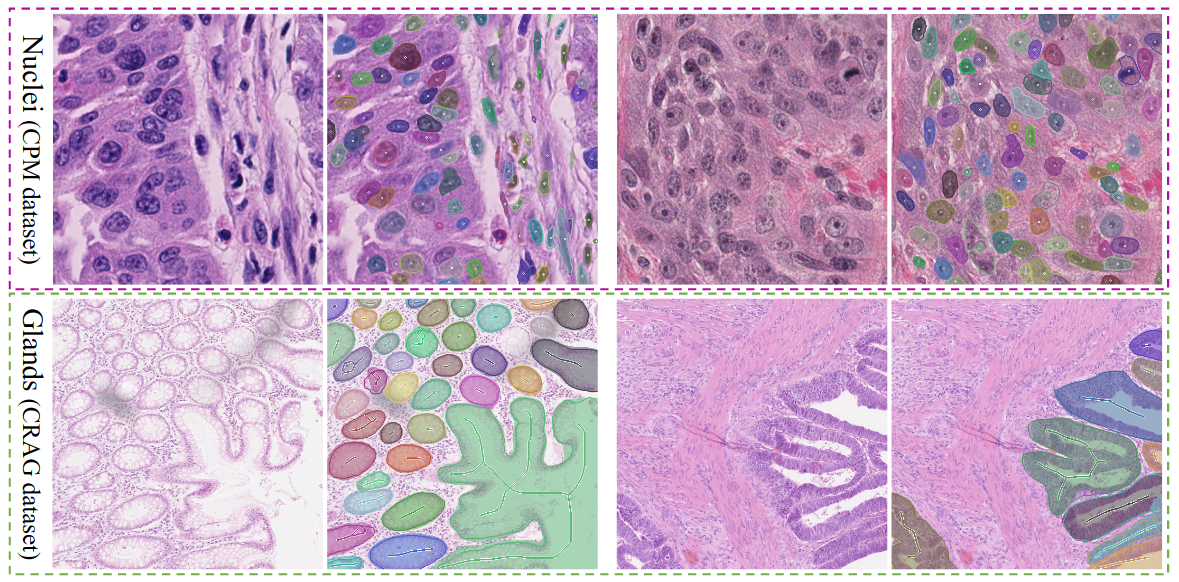
Generalizability of NuClick: The first row shows results of NuClick on CPM dataset for nuclei segmentation (where the network was trained on MoNuSeg dataset). The second row illustrates two samples of gland segmentation task from CRAG dataset where the model was trained on GLaS dataset. Solid stroke line around each object outlines the ground truth boundary for that object, overlaid transparent mask is the predicted segmentation region by NuClick, and points or squiggles indicate the provided guiding signal for interactive segmentation

### Features in the tutorial:
* Utilizes new transforms that were added/updated for v1.1 of MONAI.
* Data pre-processing functions, as typically pathology data is given as a whole slide, which cannot be directly used for training as it's too large in size, in particular check `split_concep_dataset`
* Uses the dataset: 

This model is trained using [BasicUNet](https://docs.monai.io/en/latest/networks.html#basicunet) over [ConSeP](https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet) dataset.

References:

[1] Koohbanani, Navid Alemi, et al. "NuClick: a deep learning framework for interactive segmentation of microscopic images." Medical Image Analysis 65 (2020): 101771. https://arxiv.org/abs/2005.14511.

[2] S. Graham, Q. D. Vu, S. E. A. Raza, A. Azam, Y-W. Tsang, J. T. Kwak and N. Rajpoot. "HoVer-Net: Simultaneous Segmentation and Classification of Nuclei in Multi-Tissue Histology Images." Medical Image Analysis, Sept. 2019. [[doi](https://doi.org/10.1016/j.media.2019.101563)]

[3] NuClick [PyTorch](https://github.com/mostafajahanifar/nuclick_torch) Implementation

In [1]:
!python -c "import scipy" || pip install -q scipy
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import tqdm" || pip install -q tqdm
%matplotlib inline

In [11]:
import os
import copy
import glob
import json
import logging
import os
import pathlib
import shutil
import numpy as np

from typing import Dict, List
from monai.apps.utils import download_and_extract, tqdm
from scipy.io import loadmat

## Configure Workspace Path

Specify the workspace path where the data, models etc.. will be saved.



In [4]:
workspace_path = os.path.normpath('workspace/')

## Configure Workspace Path

In [5]:
consep_zip = 'https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep_dataset.zip'
download_and_extract(consep_zip, output_dir=workspace_path)

consep_dir = os.path.join(workspace_path, 'CoNSeP')

consep_dataset.zip: 146MB [00:21, 7.27MB/s]                                                                                                                                                                                                                    

2022-12-04 06:39:03,708 - INFO - Downloaded: /tmp/tmp8ofwr6y7/consep_dataset.zip
2022-12-04 06:39:03,709 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmp8ofwr6y7/consep_dataset.zip.
2022-12-04 06:39:03,710 - INFO - Writing into directory: workspace.


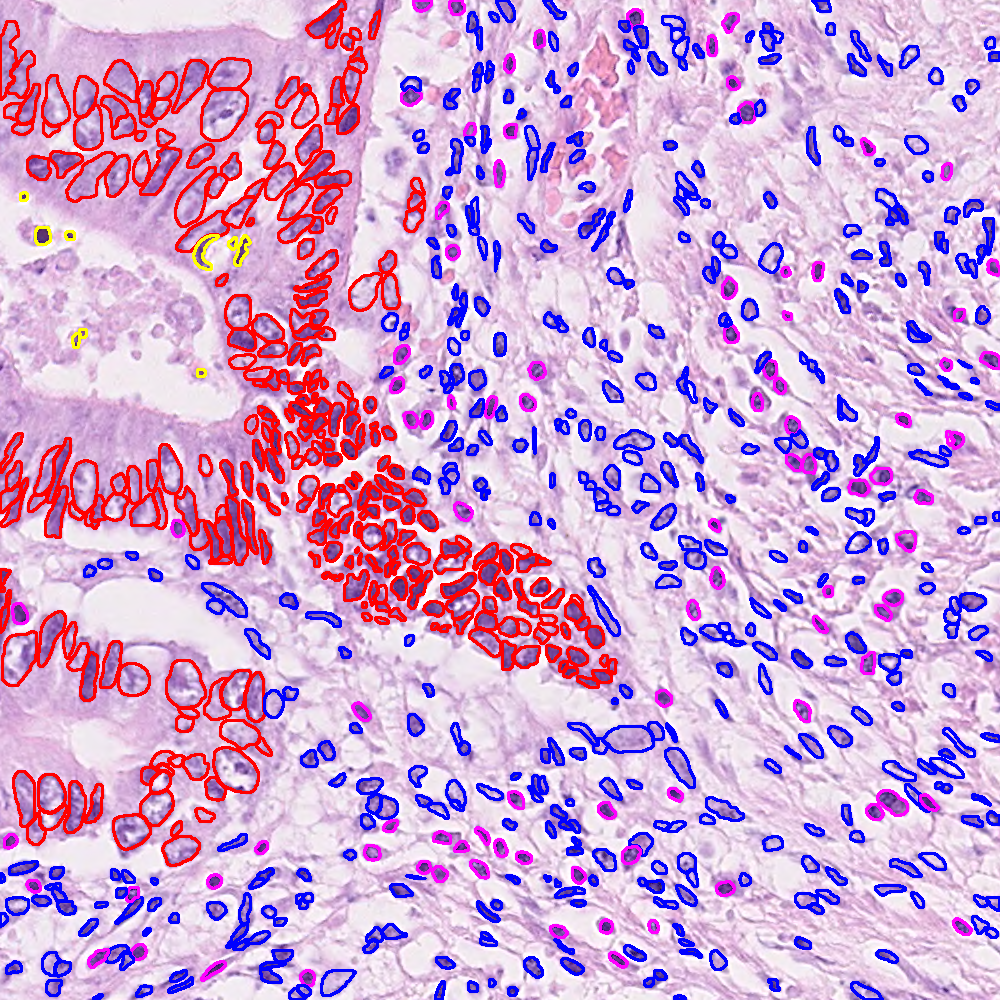

In [8]:
from IPython.display import Image
Image(filename=os.path.join(consep_dir, "Train", "Overlay", "train_1.png"))

## Pre-processing utility functions

`consep_nuclei_dataset` reads the raw Image and Matlab files provided in ConSeP dataset.  For each Nuclei it tries to create a patch of 128x128 with single nuclei labeled with correspnding class index and rest of the nuclei falling in this patch are labeled as others (mask_value: 255)



In [12]:
from PIL import Image

def consep_nuclei_dataset(datalist, output_dir, crop_size, min_area=80, min_distance=20, limit=0) -> List[Dict]:
    """
    Utility to pre-process and create dataset list for Patches per Nuclei for training over ConSeP dataset.

    Args:
        datalist: A list of data dictionary. Each entry should at least contain 'image_key': <image filename>.
            For example, typical input data can be a list of dictionaries::

                [{'image': <image filename>, 'label': <label filename>}]

        output_dir: target directory to store the training data after flattening
        crop_size: Crop Size for each patch
        min_area: Min Area for each nuclei to be included in dataset
        min_distance: Min Distance from boundary for each nuclei to be included in dataset
        limit: limit number of inputs for pre-processing.  Defaults to 0 (no limit).

    Raises:
        ValueError: When ``datalist`` is Empty
        ValueError: When ``scipy.io.loadmat`` is Not available

    Returns:
        A new datalist that contains path to the images/labels after pre-processing.

    Example::

        datalist = consep_nuclei_dataset(
            datalist=[{'image': 'img1.png', 'label': 'label1.mat'}],
            output_dir=output,
            crop_size=128,
            limit=1,
        )

        print(datalist[0]["image"], datalist[0]["label"])
    """

    if not len(datalist):
        raise ValueError("Input datalist is empty")

    if not loadmat:
        print("Please make sure scipy with loadmat function is correctly installed")
        raise ValueError("scipy.io.loadmat module/function not found")

    dataset_json: List[Dict] = []
    for d in tqdm(datalist):
        # Image
        image = Image.open(d["image"]).convert("RGB")

        # Label
        m = loadmat(d["label"])
        instances = m["inst_map"]

        for nuclei_id, (class_id, (y, x)) in enumerate(zip(m["inst_type"], m["inst_centroid"]), start=1):
            x, y = (int(x), int(y))
            class_id = int(class_id)
            class_id = 3 if class_id in (3, 4) else 4 if class_id in (5, 6, 7) else class_id  # override

            if 0 < limit <= len(dataset_json):
                return dataset_json

            item = __prepare_patch(
                d=d,
                nuclei_id=nuclei_id,
                output_dir=output_dir,
                image=image,
                instances=instances,
                instance_idx=nuclei_id,
                crop_size=crop_size,
                class_id=class_id,
                centroid=(x, y),
                min_area=min_area,
                min_distance=min_distance,
                others_idx=255,
            )

            if item:
                dataset_json.append(item)

    return dataset_json


def __prepare_patch(
    d,
    nuclei_id,
    output_dir,
    image,
    instances,
    instance_idx,
    crop_size,
    class_id,
    centroid,
    min_area,
    min_distance,
    others_idx=255,
):
    image_np = np.array(image)
    image_size = image.size

    bbox = __compute_bbox(crop_size, centroid, image_size)

    cropped_label_np = instances[bbox[0] : bbox[2], bbox[1] : bbox[3]]
    cropped_label_np = np.array(cropped_label_np)

    this_label = np.where(cropped_label_np == instance_idx, class_id, 0)
    if np.count_nonzero(this_label) < min_area:
        return None

    x, y = centroid
    if x < min_distance or y < min_distance or (image_size[0] - x) < min_distance or (image_size[1] - y < min_distance):
        return None

    centroid = centroid[0] - bbox[0], centroid[1] - bbox[1]
    others = np.where(np.logical_and(cropped_label_np > 0, cropped_label_np != instance_idx), others_idx, 0)
    cropped_label_np = this_label + others
    cropped_label = Image.fromarray(cropped_label_np.astype(np.uint8), None)

    cropped_image_np = image_np[bbox[0] : bbox[2], bbox[1] : bbox[3], :]
    cropped_image = Image.fromarray(cropped_image_np, "RGB")

    images_dir = os.path.join(output_dir, "Images") if output_dir else "Images"
    labels_dir = os.path.join(output_dir, "Labels") if output_dir else "Labels"
    centroids_dir = os.path.join(output_dir, "Centroids") if output_dir else "Centroids"

    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(centroids_dir, exist_ok=True)

    image_id = pathlib.Path(d["image"]).stem
    file_prefix = f"{image_id}_{class_id}_{str(instance_idx).zfill(4)}"
    image_file = os.path.join(images_dir, f"{file_prefix}.png")
    label_file = os.path.join(labels_dir, f"{file_prefix}.png")
    centroid_file = os.path.join(centroids_dir, f"{file_prefix}.txt")

    cropped_image.save(image_file)
    cropped_label.save(label_file)
    with open(centroid_file, "w") as fp:
        json.dump([centroid], fp)

    item = copy.deepcopy(d)
    item["nuclei_id"] = nuclei_id
    item["mask_value"] = class_id
    item["image"] = image_file
    item["label"] = label_file
    item["centroid"] = centroid
    return item


def __compute_bbox(patch_size, centroid, size):
    x, y = centroid
    m, n = size

    x_start = int(max(x - patch_size / 2, 0))
    y_start = int(max(y - patch_size / 2, 0))
    x_end = x_start + patch_size
    y_end = y_start + patch_size
    if x_end > m:
        x_end = m
        x_start = m - patch_size
    if y_end > n:
        y_end = n
        y_start = n - patch_size
    return x_start, y_start, x_end, y_end

## Create Json, form training and validation split


In [13]:
consep_nuclei_dir = os.path.join(workspace_path, 'CoNSePNuclei')
ds_file = os.path.join(consep_nuclei_dir, "dataset.json")

crop_size = 128
limit = 0 # Process all records


shutil.rmtree(consep_nuclei_dir, ignore_errors=True)
dataset_json = {}

for f, v in {"Train": "training", "Test": "validation"}.items():
    print("---------------------------------------------------------------------------------")
    if not os.path.exists(os.path.join(consep_dir, f)):
        print(f"Ignore {f} (NOT Exists in Input Folder)")
        continue

    print(f"Processing Images/labels for: {f}")
    images_path = os.path.join(consep_dir, f, "Images", "*.png")
    labels_path = os.path.join(consep_dir, f, "Labels", "*.mat")
    images = sorted(glob.glob(images_path))
    labels = sorted(glob.glob(labels_path))
    ds = [{"image": i, "label": l} for i, l in zip(images, labels)]

    output_dir = os.path.join(consep_nuclei_dir, f) if consep_nuclei_dir else f

    ds_new = consep_nuclei_dataset(ds, output_dir, crop_size, limit=limit)
    print(f"Total Generated/Extended Records: {len(ds)} => {len(ds_new)}")

    dataset_json[v] = ds_new

# Saving Dataset JSON for both training and validation
with open(ds_file, "w") as fp:
    json.dump(dataset_json, fp, indent=2)

print(f"Dataset JSON Generated at: {ds_file}")


---------------------------------------------------------------------------------
Processing Images/labels for: Train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [01:55<00:00,  4.28s/it]


Total Generated/Extended Records: 27 => 13136
---------------------------------------------------------------------------------
Processing Images/labels for: Test


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [01:05<00:00,  4.67s/it]


Total Generated/Extended Records: 14 => 7299
Dataset JSON Generated at: workspace/CoNSePNuclei/dataset.json


{
  "image": "workspace/CoNSePNuclei/Train/Images/train_1_3_0001.png",
  "label": "workspace/CoNSePNuclei/Train/Labels/train_1_3_0001.png",
  "nuclei_id": 1,
  "mask_value": 3,
  "centroid": [
    64,
    64
  ]
}
Mask Values: [  0   3 255]
-------------------------------------------------
This Nuclei
Image: torch.Size([128, 128, 3]); Label: (128, 128)


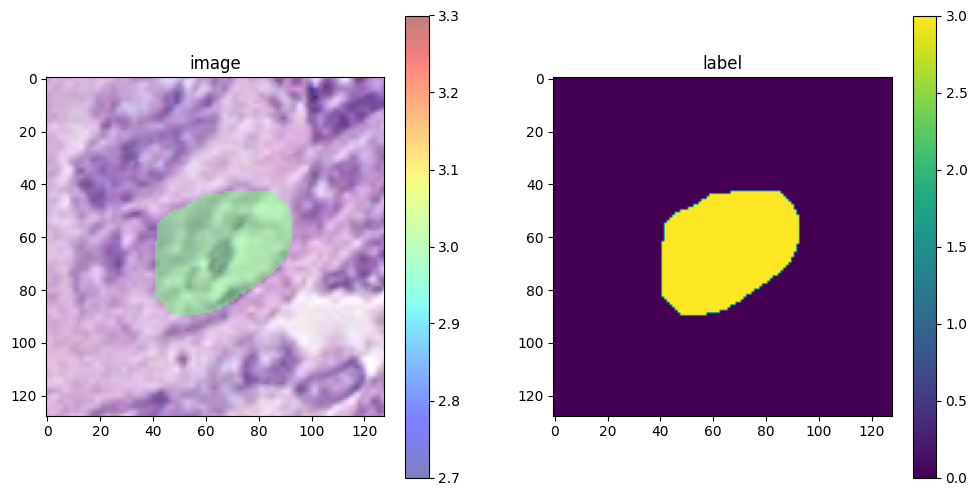

-------------------------------------------------
Others Nuclei
Image: torch.Size([128, 128, 3]); Label: (128, 128)


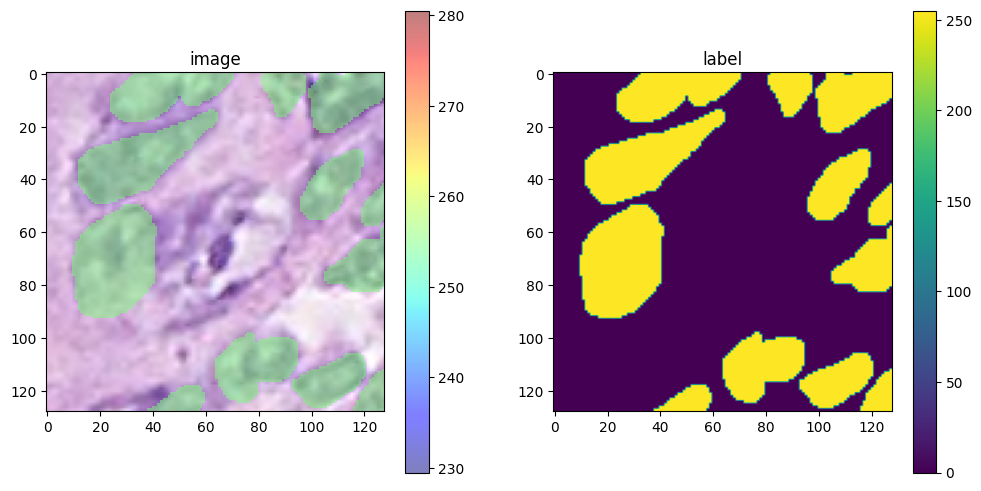

In [14]:
import matplotlib.pyplot as plt
from monai.transforms import LoadImage
import json
from PIL import ImageDraw

def show_image(image, label, points=None):
    print(f"Image: {image.shape}; Label: {label.shape}")

    if image.shape[0] == 3:
        image = np.moveaxis(image, 0, 2)
        label = np.moveaxis(label, 0, 2)

    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap="gray")

    if label is not None:
        masked = np.ma.masked_where(label == 0, label)
        plt.imshow(masked, 'jet', interpolation='none', alpha=0.5)

        
    if points is not None:
        draw_points(points)

    plt.colorbar()

    if label is not None:
        plt.subplot(1, 2, 2)
        plt.title("label")
        plt.imshow(label)
        plt.colorbar()
    plt.show()


def draw_points(guidance):
    if guidance is None:
        return
    colors = ['y+', 'b+']
    for color, points in zip(colors, guidance):
        print(points)
        for p in points:
            p1 = p[1]
            p2 = p[0]
            plt.plot(p1, p2, color, 'MarkerSize', 120)

print(json.dumps(dataset_json["training"][0], indent=2))
image = LoadImage(image_only=True, dtype=np.uint8)(dataset_json["training"][0]["image"])
label = LoadImage(image_only=True, dtype=np.uint8)(dataset_json["training"][0]["label"])
print(f"Mask Values: {np.unique(label)}")

print("-------------------------------------------------")
print("This Nuclei")
show_image(image, np.where(label < 255, label, 0))

print("-------------------------------------------------")
print("Others Nuclei")
show_image(image, np.where(label == 255, 255, 0))

## Training & Validation Transforms

In [15]:
from monai.apps.nuclick.transforms import AddPointGuidanceSignald, SplitLabeld

from monai.transforms import (
    Compose,
    Activationsd,
    AsDiscreted,
    EnsureChannelFirstd,
    LoadImaged,
    RandFlipd,
    RandRotate90d,
    RandTorchVisiond,
    ScaleIntensityRangeD,
    SelectItemsd,
)

# Transforms
train_pre_transforms = Compose([
    LoadImaged(keys=("image", "label"), dtype=np.uint8),
    EnsureChannelFirstd(keys=("image", "label")),
    SplitLabeld(keys="label", mask_value=None, others_value=255),
    RandTorchVisiond(
        keys="image",
        name="ColorJitter",
        brightness=64.0 / 255.0,
        contrast=0.75,
        saturation=0.25,
        hue=0.04,
    ),
    RandFlipd(keys=("image", "label", "others"), prob=0.5),
    RandRotate90d(keys=("image", "label", "others"), prob=0.5, spatial_axes=(0, 1)),
    ScaleIntensityRangeD(keys="image", a_min=0.0, a_max=255.0, b_min=-1.0, b_max=1.0),
    AddPointGuidanceSignald(image="image", label="label", others="others", use_distance=True, gaussian=False),
    SelectItemsd(keys=("image", "label")),
])

train_post_transforms = Compose([
    Activationsd(keys="pred", sigmoid=True),
    AsDiscreted(keys="pred", threshold=0.5),
])

val_transforms = Compose([
    LoadImaged(keys=("image", "label"), dtype=np.uint8),
    EnsureChannelFirstd(keys=("image", "label")),
    SplitLabeld(keys="label", mask_value=None, others_value=255),
    ScaleIntensityRangeD(keys="image", a_min=0.0, a_max=255.0, b_min=-1.0, b_max=1.0),
    AddPointGuidanceSignald(
        image="image",
        label="label",
        others="others",
        use_distance=True,
        gaussian=False,
        drop_rate=1.0,
    ),
    SelectItemsd(keys=("image", "label")),
])

val_pos_transforms = train_post_transforms

## NuClick Handler to verify Input/Output

In [16]:
import logging
from typing import TYPE_CHECKING, Callable, Optional

import numpy as np
import torch
import torch.distributed
from monai.config import IgniteInfo
from monai.utils import min_version, optional_import

Events, _ = optional_import("ignite.engine", IgniteInfo.OPT_IMPORT_VERSION, min_version, "Events")
make_grid, _ = optional_import("torchvision.utils", name="make_grid")
Image, _ = optional_import("PIL.Image")
ImageDraw, _ = optional_import("PIL.ImageDraw")

if TYPE_CHECKING:
    from ignite.engine import Engine
    from torch.utils.tensorboard import SummaryWriter
else:
    Engine, _ = optional_import("ignite.engine", IgniteInfo.OPT_IMPORT_VERSION, min_version, "Engine")
    SummaryWriter, _ = optional_import("torch.utils.tensorboard", name="SummaryWriter")


class TensorBoardImageHandler:
    def __init__(
        self,
        summary_writer: Optional[SummaryWriter] = None,
        log_dir: str = "./runs",
        tag_name="val",
        interval: int = 1,
        batch_transform: Callable = lambda x: x,
        output_transform: Callable = lambda x: x,
        batch_limit=1,
        device=None,
    ) -> None:
        self.writer = SummaryWriter(log_dir=log_dir) if summary_writer is None else summary_writer
        self.tag_name = tag_name
        self.interval = interval
        self.batch_transform = batch_transform
        self.output_transform = output_transform
        self.batch_limit = batch_limit
        self.device = device

        self.logger = logging.getLogger(__name__)

        if torch.distributed.is_initialized():
            self.tag_name = f"{self.tag_name}-r{torch.distributed.get_rank()}"

    def attach(self, engine: Engine) -> None:
        engine.add_event_handler(Events.EPOCH_COMPLETED(every=self.interval), self, "epoch")

    def __call__(self, engine: Engine, action) -> None:
        epoch = engine.state.epoch
        batch_data = self.batch_transform(engine.state.batch)
        output_data = self.output_transform(engine.state.output)

        self.write_images(batch_data, output_data, epoch)

    def write_images(self, batch_data, output_data, epoch):
        for bidx in range(len(batch_data)):
            image = batch_data[bidx]["image"].detach().cpu().numpy()
            y = output_data[bidx]["label"].detach().cpu().numpy()

            tag_prefix = f"{self.tag_name} - b{bidx} - " if self.batch_limit != 1 else ""
            img_np = image[:3]
            img_np[0, :, :] = np.where(y[0] > 0, 1, img_np[0, :, :])
            img_tensor = make_grid(torch.from_numpy(img_np), normalize=True)
            self.writer.add_image(tag=f"{tag_prefix}Image", img_tensor=img_tensor, global_step=epoch)

            y_pred = output_data[bidx]["pred"].detach().cpu().numpy()

            c_y = np.count_nonzero(y)
            c_y_pred = np.count_nonzero(y_pred)
            c_pos = np.count_nonzero(image[3])
            c_neg = np.count_nonzero(image[4])

            if bidx == 0:
                self.logger.info(f"{self.tag_name} => Image: {image.shape}; Label: {y.shape}; Pred: {y_pred.shape}")
            
            self.logger.info(
                "{} => {} - Label: {}; Pred: {}; Diff: {:.2f}%; Pos: {}; Neg: {}".format(
                    self.tag_name,
                    bidx,
                    c_y,
                    c_y_pred,
                    100 * (c_y_pred - c_y) / (c_y + 1),
                    c_pos,
                    c_neg,
                )
            )

            tag_prefix = f"{self.tag_name} - b{bidx} - " if self.batch_limit != 1 else f"{self.tag_name} - "
            label_pred = [y, y_pred, image[3][None] > 0, image[4][None] > 0]
            label_pred_tag = f"{tag_prefix}Label vs Pred vs Pos vs Neg"

            img_tensor = make_grid(tensor=torch.from_numpy(np.array(label_pred)), nrow=4, normalize=True, pad_value=10)
            self.writer.add_image(tag=label_pred_tag, img_tensor=img_tensor, global_step=epoch)

            if self.batch_limit == 1 or bidx == (self.batch_limit - 1):
                break


## Training of NuClick Model

In [17]:
import torch
from monai.handlers import from_engine, MeanDice, CheckpointSaver, ValidationHandler, StatsHandler
from monai.data import CacheDataset, DataLoader
from monai.engines import SupervisedEvaluator, SupervisedTrainer
from monai.networks.nets import BasicUNet
from monai.losses import DiceLoss
from monai.inferers import SimpleInferer


train_key_metric = {"train_dice": MeanDice(include_background=False, output_transform=from_engine(["pred", "label"]))}
val_key_metric = {"val_dice": MeanDice(include_background=False, output_transform=from_engine(["pred", "label"]))}
val_inferer = SimpleInferer()
log_dir = os.path.join(workspace_path, "train_run_01")


amp=True
max_epochs=50

# Define Dataset & Loading
train_data_set = CacheDataset(dataset_json["training"], transform=train_pre_transforms)
train_data_loader = DataLoader(dataset=train_data_set, batch_size=64, shuffle=True, num_workers=0)

val_data_set = CacheDataset(dataset_json["validation"], transform=val_transforms)
val_data_loader = DataLoader(dataset=val_data_set, batch_size=64, shuffle=False, num_workers=0)

# Network Definition, Optimizer etc
device = torch.device("cuda")
network = BasicUNet(spatial_dims=2, in_channels=5, out_channels=1, features=(32, 64, 128, 256, 512, 32))

network.to(device)
optimizer = torch.optim.Adam(network.parameters(), 0.0001)
dice_loss = DiceLoss(sigmoid=True, squared_pred=True)

# Training Process
val_handlers = [
    TensorBoardImageHandler(log_dir=log_dir, batch_limit=4, tag_name="val"),
    CheckpointSaver(save_dir=log_dir, save_dict={"network": network}, save_key_metric=True, key_metric_filename="model.pt"),
]

evaluator = SupervisedEvaluator(
    device=device,
    val_data_loader=val_data_loader,
    network=network,
    inferer=val_inferer,
    postprocessing=train_post_transforms,
    key_val_metric=val_key_metric,
    val_handlers=val_handlers,
    amp=amp,
)

train_handlers = [
    ValidationHandler(validator=evaluator, interval=1, epoch_level=True),
    StatsHandler(tag_name="train_loss", output_transform=from_engine(["loss"], first=True)),
    TensorBoardImageHandler(log_dir=log_dir, batch_limit=4, tag_name="train"),
]

trainer = SupervisedTrainer(
    device=device,
    max_epochs=max_epochs,
    train_data_loader=train_data_loader,
    network=network,
    optimizer=optimizer,
    loss_function=dice_loss,
    inferer=SimpleInferer(),
    amp=amp,
    postprocessing=train_post_transforms,
    key_train_metric=train_key_metric,
    train_handlers=train_handlers,
)
trainer.run()

Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7299/7299 [00:31<00:00, 232.66it/s]


BasicUNet features: (32, 64, 128, 256, 512, 32).
2022-12-04 06:47:18,867 - Engine run resuming from iteration 0, epoch 0 until 50 epochs
2022-12-04 06:47:22,954 - Epoch: 1/50, Iter: 1/206 -- train_loss: 0.9266 
2022-12-04 06:47:23,811 - Epoch: 1/50, Iter: 2/206 -- train_loss: 0.9276 
2022-12-04 06:47:24,596 - Epoch: 1/50, Iter: 3/206 -- train_loss: 0.9184 
2022-12-04 06:47:25,419 - Epoch: 1/50, Iter: 4/206 -- train_loss: 0.9141 
2022-12-04 06:47:26,211 - Epoch: 1/50, Iter: 5/206 -- train_loss: 0.9051 
2022-12-04 06:47:27,029 - Epoch: 1/50, Iter: 6/206 -- train_loss: 0.9002 
2022-12-04 06:47:27,829 - Epoch: 1/50, Iter: 7/206 -- train_loss: 0.8867 
2022-12-04 06:47:28,717 - Epoch: 1/50, Iter: 8/206 -- train_loss: 0.9078 
2022-12-04 06:47:29,491 - Epoch: 1/50, Iter: 9/206 -- train_loss: 0.9133 
2022-12-04 06:47:30,281 - Epoch: 1/50, Iter: 10/206 -- train_loss: 0.9072 
2022-12-04 06:47:31,062 - Epoch: 1/50, Iter: 11/206 -- train_loss: 0.8971 
2022-12-04 06:47:31,877 - Epoch: 1/50, Iter: 12

2022-12-04 06:48:49,441 - Epoch: 1/50, Iter: 109/206 -- train_loss: 0.7635 
2022-12-04 06:48:50,193 - Epoch: 1/50, Iter: 110/206 -- train_loss: 0.7659 
2022-12-04 06:48:51,021 - Epoch: 1/50, Iter: 111/206 -- train_loss: 0.7491 
2022-12-04 06:48:51,805 - Epoch: 1/50, Iter: 112/206 -- train_loss: 0.7524 
2022-12-04 06:48:52,575 - Epoch: 1/50, Iter: 113/206 -- train_loss: 0.7668 
2022-12-04 06:48:53,339 - Epoch: 1/50, Iter: 114/206 -- train_loss: 0.7763 
2022-12-04 06:48:54,145 - Epoch: 1/50, Iter: 115/206 -- train_loss: 0.7646 
2022-12-04 06:48:54,971 - Epoch: 1/50, Iter: 116/206 -- train_loss: 0.7564 
2022-12-04 06:48:55,775 - Epoch: 1/50, Iter: 117/206 -- train_loss: 0.7543 
2022-12-04 06:48:56,559 - Epoch: 1/50, Iter: 118/206 -- train_loss: 0.7580 
2022-12-04 06:48:57,368 - Epoch: 1/50, Iter: 119/206 -- train_loss: 0.7586 
2022-12-04 06:48:58,185 - Epoch: 1/50, Iter: 120/206 -- train_loss: 0.7577 
2022-12-04 06:48:58,970 - Epoch: 1/50, Iter: 121/206 -- train_loss: 0.7382 
2022-12-04 0

2022-12-04 06:50:39,562 - Epoch[1] Metrics -- train_dice: 0.4735 
2022-12-04 06:50:39,563 - Key metric: train_dice best value: 0.4734755754470825 at epoch: 1
2022-12-04 06:50:39,583 - train => Image: (5, 128, 128); Label: (1, 128, 128); Pred: (1, 128, 128)
2022-12-04 06:50:39,584 - train => 0 - Label: 234; Pred: 337; Diff: 43.83%; Pos: 1; Neg: 7
2022-12-04 06:50:39,612 - train => 1 - Label: 1013; Pred: 668; Diff: -34.02%; Pos: 1; Neg: 7
2022-12-04 06:50:39,642 - train => 2 - Label: 132; Pred: 361; Diff: 172.18%; Pos: 1; Neg: 15
2022-12-04 06:50:39,667 - train => 3 - Label: 97; Pred: 363; Diff: 271.43%; Pos: 1; Neg: 6
2022-12-04 06:50:39,676 - Epoch[1] Complete. Time taken: 00:03:20.807
2022-12-04 06:50:40,577 - Epoch: 2/50, Iter: 1/206 -- train_loss: 0.7123 
2022-12-04 06:50:41,374 - Epoch: 2/50, Iter: 2/206 -- train_loss: 0.6998 
2022-12-04 06:50:42,177 - Epoch: 2/50, Iter: 3/206 -- train_loss: 0.7004 
2022-12-04 06:50:42,988 - Epoch: 2/50, Iter: 4/206 -- train_loss: 0.7066 
2022-12-0

2022-12-04 06:52:02,167 - Epoch: 2/50, Iter: 102/206 -- train_loss: 0.6603 
2022-12-04 06:52:02,953 - Epoch: 2/50, Iter: 103/206 -- train_loss: 0.6502 
2022-12-04 06:52:03,764 - Epoch: 2/50, Iter: 104/206 -- train_loss: 0.6577 
2022-12-04 06:52:04,570 - Epoch: 2/50, Iter: 105/206 -- train_loss: 0.6581 
2022-12-04 06:52:05,359 - Epoch: 2/50, Iter: 106/206 -- train_loss: 0.6883 
2022-12-04 06:52:06,164 - Epoch: 2/50, Iter: 107/206 -- train_loss: 0.6452 
2022-12-04 06:52:06,971 - Epoch: 2/50, Iter: 108/206 -- train_loss: 0.6248 
2022-12-04 06:52:07,776 - Epoch: 2/50, Iter: 109/206 -- train_loss: 0.6573 
2022-12-04 06:52:08,557 - Epoch: 2/50, Iter: 110/206 -- train_loss: 0.6765 
2022-12-04 06:52:09,357 - Epoch: 2/50, Iter: 111/206 -- train_loss: 0.6463 
2022-12-04 06:52:10,166 - Epoch: 2/50, Iter: 112/206 -- train_loss: 0.6577 
2022-12-04 06:52:10,949 - Epoch: 2/50, Iter: 113/206 -- train_loss: 0.6254 
2022-12-04 06:52:11,760 - Epoch: 2/50, Iter: 114/206 -- train_loss: 0.6640 
2022-12-04 0

2022-12-04 06:53:57,929 - val => Image: (5, 128, 128); Label: (1, 128, 128); Pred: (1, 128, 128)
2022-12-04 06:53:57,930 - val => 0 - Label: 83; Pred: 328; Diff: 291.67%; Pos: 1; Neg: 0
2022-12-04 06:53:57,955 - val => 1 - Label: 82; Pred: 274; Diff: 231.33%; Pos: 1; Neg: 0
2022-12-04 06:53:57,981 - val => 2 - Label: 81; Pred: 507; Diff: 519.51%; Pos: 1; Neg: 0
2022-12-04 06:53:58,055 - Epoch[2] Complete. Time taken: 00:00:32.701
2022-12-04 06:53:58,056 - Engine run complete. Time taken: 00:00:32.703
2022-12-04 06:53:58,057 - Epoch[2] Metrics -- train_dice: 0.6577 
2022-12-04 06:53:58,058 - Key metric: train_dice best value: 0.6577173471450806 at epoch: 2
2022-12-04 06:53:58,083 - train => Image: (5, 128, 128); Label: (1, 128, 128); Pred: (1, 128, 128)
2022-12-04 06:53:58,084 - train => 0 - Label: 175; Pred: 228; Diff: 30.11%; Pos: 1; Neg: 0
2022-12-04 06:53:58,101 - train => 1 - Label: 119; Pred: 312; Diff: 160.83%; Pos: 1; Neg: 0
2022-12-04 06:53:58,145 - train => 2 - Label: 576; Pre

2022-12-04 06:55:15,193 - Epoch: 3/50, Iter: 95/206 -- train_loss: 0.5301 
2022-12-04 06:55:15,991 - Epoch: 3/50, Iter: 96/206 -- train_loss: 0.5182 
2022-12-04 06:55:16,813 - Epoch: 3/50, Iter: 97/206 -- train_loss: 0.5255 
2022-12-04 06:55:17,627 - Epoch: 3/50, Iter: 98/206 -- train_loss: 0.5438 
2022-12-04 06:55:18,425 - Epoch: 3/50, Iter: 99/206 -- train_loss: 0.5232 
2022-12-04 06:55:19,211 - Epoch: 3/50, Iter: 100/206 -- train_loss: 0.5484 
2022-12-04 06:55:20,018 - Epoch: 3/50, Iter: 101/206 -- train_loss: 0.5083 
2022-12-04 06:55:20,816 - Epoch: 3/50, Iter: 102/206 -- train_loss: 0.5339 
2022-12-04 06:55:21,623 - Epoch: 3/50, Iter: 103/206 -- train_loss: 0.5355 
2022-12-04 06:55:22,420 - Epoch: 3/50, Iter: 104/206 -- train_loss: 0.5209 
2022-12-04 06:55:23,221 - Epoch: 3/50, Iter: 105/206 -- train_loss: 0.5207 
2022-12-04 06:55:24,014 - Epoch: 3/50, Iter: 106/206 -- train_loss: 0.5097 
2022-12-04 06:55:24,866 - Epoch: 3/50, Iter: 107/206 -- train_loss: 0.5418 
2022-12-04 06:55:

2022-12-04 06:56:42,831 - Epoch: 3/50, Iter: 203/206 -- train_loss: 0.4393 
2022-12-04 06:56:43,661 - Epoch: 3/50, Iter: 204/206 -- train_loss: 0.4579 
2022-12-04 06:56:44,474 - Epoch: 3/50, Iter: 205/206 -- train_loss: 0.4724 
2022-12-04 06:56:44,702 - Epoch: 3/50, Iter: 206/206 -- train_loss: 0.4281 
2022-12-04 06:56:44,716 - Got new best metric of train_dice: 0.7465816140174866
2022-12-04 06:56:44,717 - Engine run resuming from iteration 0, epoch 2 until 3 epochs
2022-12-04 06:57:17,263 - Got new best metric of val_dice: 0.7609909176826477
2022-12-04 06:57:17,284 - val => Image: (5, 128, 128); Label: (1, 128, 128); Pred: (1, 128, 128)
2022-12-04 06:57:17,284 - val => 0 - Label: 83; Pred: 214; Diff: 155.95%; Pos: 1; Neg: 0
2022-12-04 06:57:17,309 - val => 1 - Label: 82; Pred: 179; Diff: 116.87%; Pos: 1; Neg: 0
2022-12-04 06:57:17,337 - val => 2 - Label: 81; Pred: 261; Diff: 219.51%; Pos: 1; Neg: 0
2022-12-04 06:57:17,414 - Epoch[3] Complete. Time taken: 00:00:32.696
2022-12-04 06:57:

2022-12-04 06:58:28,293 - Epoch: 4/50, Iter: 88/206 -- train_loss: 0.3897 
2022-12-04 06:58:29,083 - Epoch: 4/50, Iter: 89/206 -- train_loss: 0.3956 
2022-12-04 06:58:29,854 - Epoch: 4/50, Iter: 90/206 -- train_loss: 0.4114 
2022-12-04 06:58:30,641 - Epoch: 4/50, Iter: 91/206 -- train_loss: 0.3930 
2022-12-04 06:58:31,435 - Epoch: 4/50, Iter: 92/206 -- train_loss: 0.3704 
2022-12-04 06:58:32,227 - Epoch: 4/50, Iter: 93/206 -- train_loss: 0.3956 
2022-12-04 06:58:33,021 - Epoch: 4/50, Iter: 94/206 -- train_loss: 0.4117 
2022-12-04 06:58:33,824 - Epoch: 4/50, Iter: 95/206 -- train_loss: 0.3826 
2022-12-04 06:58:34,618 - Epoch: 4/50, Iter: 96/206 -- train_loss: 0.3793 
2022-12-04 06:58:35,392 - Epoch: 4/50, Iter: 97/206 -- train_loss: 0.3812 
2022-12-04 06:58:36,183 - Epoch: 4/50, Iter: 98/206 -- train_loss: 0.3859 
2022-12-04 06:58:37,005 - Epoch: 4/50, Iter: 99/206 -- train_loss: 0.3926 
2022-12-04 06:58:37,778 - Epoch: 4/50, Iter: 100/206 -- train_loss: 0.3628 
2022-12-04 06:58:38,580 

2022-12-04 06:59:54,364 - Epoch: 4/50, Iter: 196/206 -- train_loss: 0.3425 
2022-12-04 06:59:55,221 - Epoch: 4/50, Iter: 197/206 -- train_loss: 0.3500 
2022-12-04 06:59:56,030 - Epoch: 4/50, Iter: 198/206 -- train_loss: 0.3458 
2022-12-04 06:59:56,816 - Epoch: 4/50, Iter: 199/206 -- train_loss: 0.3457 
2022-12-04 06:59:57,612 - Epoch: 4/50, Iter: 200/206 -- train_loss: 0.3452 
2022-12-04 06:59:58,448 - Epoch: 4/50, Iter: 201/206 -- train_loss: 0.3226 
2022-12-04 06:59:59,246 - Epoch: 4/50, Iter: 202/206 -- train_loss: 0.3013 
2022-12-04 07:00:00,044 - Epoch: 4/50, Iter: 203/206 -- train_loss: 0.3576 
2022-12-04 07:00:00,875 - Epoch: 4/50, Iter: 204/206 -- train_loss: 0.3087 
2022-12-04 07:00:01,671 - Epoch: 4/50, Iter: 205/206 -- train_loss: 0.3228 
2022-12-04 07:00:01,917 - Epoch: 4/50, Iter: 206/206 -- train_loss: 0.4028 
2022-12-04 07:00:01,932 - Got new best metric of train_dice: 0.7923036217689514
2022-12-04 07:00:01,933 - Engine run resuming from iteration 0, epoch 3 until 4 epoc

2022-12-04 07:01:38,593 - Epoch: 5/50, Iter: 80/206 -- train_loss: 0.3025 
2022-12-04 07:01:39,404 - Epoch: 5/50, Iter: 81/206 -- train_loss: 0.3122 
2022-12-04 07:01:40,197 - Epoch: 5/50, Iter: 82/206 -- train_loss: 0.2855 
2022-12-04 07:01:40,967 - Epoch: 5/50, Iter: 83/206 -- train_loss: 0.2969 
2022-12-04 07:01:41,769 - Epoch: 5/50, Iter: 84/206 -- train_loss: 0.3063 
2022-12-04 07:01:42,547 - Epoch: 5/50, Iter: 85/206 -- train_loss: 0.2867 
2022-12-04 07:01:43,313 - Epoch: 5/50, Iter: 86/206 -- train_loss: 0.3055 
2022-12-04 07:01:44,104 - Epoch: 5/50, Iter: 87/206 -- train_loss: 0.2965 
2022-12-04 07:01:44,904 - Epoch: 5/50, Iter: 88/206 -- train_loss: 0.2862 
2022-12-04 07:01:45,709 - Epoch: 5/50, Iter: 89/206 -- train_loss: 0.2950 
2022-12-04 07:01:46,502 - Epoch: 5/50, Iter: 90/206 -- train_loss: 0.3114 
2022-12-04 07:01:47,313 - Epoch: 5/50, Iter: 91/206 -- train_loss: 0.2760 
2022-12-04 07:01:48,119 - Epoch: 5/50, Iter: 92/206 -- train_loss: 0.2882 
2022-12-04 07:01:48,893 -

2022-12-04 07:03:06,298 - Epoch: 5/50, Iter: 189/206 -- train_loss: 0.2493 
2022-12-04 07:03:07,107 - Epoch: 5/50, Iter: 190/206 -- train_loss: 0.2754 
2022-12-04 07:03:07,898 - Epoch: 5/50, Iter: 191/206 -- train_loss: 0.2493 
2022-12-04 07:03:08,729 - Epoch: 5/50, Iter: 192/206 -- train_loss: 0.2623 
2022-12-04 07:03:09,551 - Epoch: 5/50, Iter: 193/206 -- train_loss: 0.2617 
2022-12-04 07:03:10,322 - Epoch: 5/50, Iter: 194/206 -- train_loss: 0.2490 
2022-12-04 07:03:11,119 - Epoch: 5/50, Iter: 195/206 -- train_loss: 0.2734 
2022-12-04 07:03:11,942 - Epoch: 5/50, Iter: 196/206 -- train_loss: 0.2648 
2022-12-04 07:03:12,730 - Epoch: 5/50, Iter: 197/206 -- train_loss: 0.2789 
2022-12-04 07:03:13,523 - Epoch: 5/50, Iter: 198/206 -- train_loss: 0.2314 
2022-12-04 07:03:14,341 - Epoch: 5/50, Iter: 199/206 -- train_loss: 0.2516 
2022-12-04 07:03:15,157 - Epoch: 5/50, Iter: 200/206 -- train_loss: 0.2493 
2022-12-04 07:03:15,943 - Epoch: 5/50, Iter: 201/206 -- train_loss: 0.2825 
2022-12-04 0

2022-12-04 07:04:50,826 - Epoch: 6/50, Iter: 73/206 -- train_loss: 0.2341 
2022-12-04 07:04:51,651 - Epoch: 6/50, Iter: 74/206 -- train_loss: 0.2389 
2022-12-04 07:04:52,490 - Epoch: 6/50, Iter: 75/206 -- train_loss: 0.2314 
2022-12-04 07:04:53,300 - Epoch: 6/50, Iter: 76/206 -- train_loss: 0.2365 
2022-12-04 07:04:54,089 - Epoch: 6/50, Iter: 77/206 -- train_loss: 0.2445 
2022-12-04 07:04:54,940 - Epoch: 6/50, Iter: 78/206 -- train_loss: 0.2471 
2022-12-04 07:04:55,765 - Epoch: 6/50, Iter: 79/206 -- train_loss: 0.2277 
2022-12-04 07:04:56,571 - Epoch: 6/50, Iter: 80/206 -- train_loss: 0.2257 
2022-12-04 07:04:57,372 - Epoch: 6/50, Iter: 81/206 -- train_loss: 0.2136 
2022-12-04 07:04:58,189 - Epoch: 6/50, Iter: 82/206 -- train_loss: 0.2260 
2022-12-04 07:04:58,998 - Epoch: 6/50, Iter: 83/206 -- train_loss: 0.2213 
2022-12-04 07:04:59,807 - Epoch: 6/50, Iter: 84/206 -- train_loss: 0.2217 
2022-12-04 07:05:00,600 - Epoch: 6/50, Iter: 85/206 -- train_loss: 0.2167 
2022-12-04 07:05:01,414 -

2022-12-04 07:06:19,208 - Epoch: 6/50, Iter: 182/206 -- train_loss: 0.2133 
2022-12-04 07:06:20,012 - Epoch: 6/50, Iter: 183/206 -- train_loss: 0.1841 
2022-12-04 07:06:20,836 - Epoch: 6/50, Iter: 184/206 -- train_loss: 0.2068 
2022-12-04 07:06:21,653 - Epoch: 6/50, Iter: 185/206 -- train_loss: 0.1889 
2022-12-04 07:06:22,468 - Epoch: 6/50, Iter: 186/206 -- train_loss: 0.2120 
2022-12-04 07:06:23,264 - Epoch: 6/50, Iter: 187/206 -- train_loss: 0.2019 
2022-12-04 07:06:24,098 - Epoch: 6/50, Iter: 188/206 -- train_loss: 0.1948 
2022-12-04 07:06:24,970 - Epoch: 6/50, Iter: 189/206 -- train_loss: 0.1999 
2022-12-04 07:06:25,814 - Epoch: 6/50, Iter: 190/206 -- train_loss: 0.2233 
2022-12-04 07:06:26,614 - Epoch: 6/50, Iter: 191/206 -- train_loss: 0.2044 
2022-12-04 07:06:27,423 - Epoch: 6/50, Iter: 192/206 -- train_loss: 0.1992 
2022-12-04 07:06:28,214 - Epoch: 6/50, Iter: 193/206 -- train_loss: 0.2237 
2022-12-04 07:06:28,989 - Epoch: 6/50, Iter: 194/206 -- train_loss: 0.1963 
2022-12-04 0

2022-12-04 07:08:04,764 - Epoch: 7/50, Iter: 66/206 -- train_loss: 0.2239 
2022-12-04 07:08:05,583 - Epoch: 7/50, Iter: 67/206 -- train_loss: 0.2115 
2022-12-04 07:08:06,411 - Epoch: 7/50, Iter: 68/206 -- train_loss: 0.2020 
2022-12-04 07:08:07,226 - Epoch: 7/50, Iter: 69/206 -- train_loss: 0.2036 
2022-12-04 07:08:08,016 - Epoch: 7/50, Iter: 70/206 -- train_loss: 0.2182 
2022-12-04 07:08:08,819 - Epoch: 7/50, Iter: 71/206 -- train_loss: 0.1853 
2022-12-04 07:08:09,639 - Epoch: 7/50, Iter: 72/206 -- train_loss: 0.2252 
2022-12-04 07:08:10,422 - Epoch: 7/50, Iter: 73/206 -- train_loss: 0.1993 
2022-12-04 07:08:11,265 - Epoch: 7/50, Iter: 74/206 -- train_loss: 0.2162 
2022-12-04 07:08:12,107 - Epoch: 7/50, Iter: 75/206 -- train_loss: 0.2038 
2022-12-04 07:08:12,940 - Epoch: 7/50, Iter: 76/206 -- train_loss: 0.1783 
2022-12-04 07:08:13,742 - Epoch: 7/50, Iter: 77/206 -- train_loss: 0.1834 
2022-12-04 07:08:14,582 - Epoch: 7/50, Iter: 78/206 -- train_loss: 0.1702 
2022-12-04 07:08:15,394 -

2022-12-04 07:09:33,947 - Epoch: 7/50, Iter: 175/206 -- train_loss: 0.1777 
2022-12-04 07:09:34,768 - Epoch: 7/50, Iter: 176/206 -- train_loss: 0.1933 
2022-12-04 07:09:35,543 - Epoch: 7/50, Iter: 177/206 -- train_loss: 0.1800 
2022-12-04 07:09:36,346 - Epoch: 7/50, Iter: 178/206 -- train_loss: 0.1824 
2022-12-04 07:09:37,146 - Epoch: 7/50, Iter: 179/206 -- train_loss: 0.1762 
2022-12-04 07:09:37,967 - Epoch: 7/50, Iter: 180/206 -- train_loss: 0.1778 
2022-12-04 07:09:38,750 - Epoch: 7/50, Iter: 181/206 -- train_loss: 0.1732 
2022-12-04 07:09:39,568 - Epoch: 7/50, Iter: 182/206 -- train_loss: 0.1624 
2022-12-04 07:09:40,380 - Epoch: 7/50, Iter: 183/206 -- train_loss: 0.1749 
2022-12-04 07:09:41,185 - Epoch: 7/50, Iter: 184/206 -- train_loss: 0.2007 
2022-12-04 07:09:41,995 - Epoch: 7/50, Iter: 185/206 -- train_loss: 0.1764 
2022-12-04 07:09:42,815 - Epoch: 7/50, Iter: 186/206 -- train_loss: 0.1863 
2022-12-04 07:09:43,627 - Epoch: 7/50, Iter: 187/206 -- train_loss: 0.1516 
2022-12-04 0

2022-12-04 07:11:19,345 - Epoch: 8/50, Iter: 60/206 -- train_loss: 0.1575 
2022-12-04 07:11:20,141 - Epoch: 8/50, Iter: 61/206 -- train_loss: 0.1732 
2022-12-04 07:11:20,936 - Epoch: 8/50, Iter: 62/206 -- train_loss: 0.1699 
2022-12-04 07:11:21,717 - Epoch: 8/50, Iter: 63/206 -- train_loss: 0.1689 
2022-12-04 07:11:22,539 - Epoch: 8/50, Iter: 64/206 -- train_loss: 0.1549 
2022-12-04 07:11:23,349 - Epoch: 8/50, Iter: 65/206 -- train_loss: 0.1577 
2022-12-04 07:11:24,138 - Epoch: 8/50, Iter: 66/206 -- train_loss: 0.1697 
2022-12-04 07:11:24,951 - Epoch: 8/50, Iter: 67/206 -- train_loss: 0.1819 
2022-12-04 07:11:25,773 - Epoch: 8/50, Iter: 68/206 -- train_loss: 0.1772 
2022-12-04 07:11:26,590 - Epoch: 8/50, Iter: 69/206 -- train_loss: 0.1844 
2022-12-04 07:11:27,353 - Epoch: 8/50, Iter: 70/206 -- train_loss: 0.1851 
2022-12-04 07:11:28,144 - Epoch: 8/50, Iter: 71/206 -- train_loss: 0.1783 
2022-12-04 07:11:28,943 - Epoch: 8/50, Iter: 72/206 -- train_loss: 0.1684 
2022-12-04 07:11:29,722 -

2022-12-04 07:12:50,374 - Epoch: 8/50, Iter: 169/206 -- train_loss: 0.1664 
2022-12-04 07:12:51,147 - Epoch: 8/50, Iter: 170/206 -- train_loss: 0.1700 
2022-12-04 07:12:51,944 - Epoch: 8/50, Iter: 171/206 -- train_loss: 0.1493 
2022-12-04 07:12:52,718 - Epoch: 8/50, Iter: 172/206 -- train_loss: 0.1641 
2022-12-04 07:12:53,532 - Epoch: 8/50, Iter: 173/206 -- train_loss: 0.1628 
2022-12-04 07:12:54,291 - Epoch: 8/50, Iter: 174/206 -- train_loss: 0.1654 
2022-12-04 07:12:55,171 - Epoch: 8/50, Iter: 175/206 -- train_loss: 0.1679 
2022-12-04 07:12:56,044 - Epoch: 8/50, Iter: 176/206 -- train_loss: 0.1591 
2022-12-04 07:12:56,825 - Epoch: 8/50, Iter: 177/206 -- train_loss: 0.1623 
2022-12-04 07:12:57,594 - Epoch: 8/50, Iter: 178/206 -- train_loss: 0.1727 
2022-12-04 07:12:58,395 - Epoch: 8/50, Iter: 179/206 -- train_loss: 0.1460 
2022-12-04 07:12:59,167 - Epoch: 8/50, Iter: 180/206 -- train_loss: 0.1702 
2022-12-04 07:12:59,932 - Epoch: 8/50, Iter: 181/206 -- train_loss: 0.1590 
2022-12-04 0

2022-12-04 07:14:35,565 - Epoch: 9/50, Iter: 53/206 -- train_loss: 0.1709 
2022-12-04 07:14:36,394 - Epoch: 9/50, Iter: 54/206 -- train_loss: 0.1408 
2022-12-04 07:14:37,233 - Epoch: 9/50, Iter: 55/206 -- train_loss: 0.1517 
2022-12-04 07:14:38,096 - Epoch: 9/50, Iter: 56/206 -- train_loss: 0.1715 
2022-12-04 07:14:38,917 - Epoch: 9/50, Iter: 57/206 -- train_loss: 0.1601 
2022-12-04 07:14:39,748 - Epoch: 9/50, Iter: 58/206 -- train_loss: 0.1462 
2022-12-04 07:14:40,543 - Epoch: 9/50, Iter: 59/206 -- train_loss: 0.1423 
2022-12-04 07:14:41,359 - Epoch: 9/50, Iter: 60/206 -- train_loss: 0.1523 
2022-12-04 07:14:42,187 - Epoch: 9/50, Iter: 61/206 -- train_loss: 0.1616 
2022-12-04 07:14:43,011 - Epoch: 9/50, Iter: 62/206 -- train_loss: 0.1647 
2022-12-04 07:14:43,844 - Epoch: 9/50, Iter: 63/206 -- train_loss: 0.1448 
2022-12-04 07:14:44,645 - Epoch: 9/50, Iter: 64/206 -- train_loss: 0.1444 
2022-12-04 07:14:45,461 - Epoch: 9/50, Iter: 65/206 -- train_loss: 0.1464 
2022-12-04 07:14:46,293 -

2022-12-04 07:16:03,887 - Epoch: 9/50, Iter: 162/206 -- train_loss: 0.1451 
2022-12-04 07:16:04,702 - Epoch: 9/50, Iter: 163/206 -- train_loss: 0.1572 
2022-12-04 07:16:05,532 - Epoch: 9/50, Iter: 164/206 -- train_loss: 0.1352 
2022-12-04 07:16:06,330 - Epoch: 9/50, Iter: 165/206 -- train_loss: 0.1438 
2022-12-04 07:16:07,103 - Epoch: 9/50, Iter: 166/206 -- train_loss: 0.1542 
2022-12-04 07:16:07,922 - Epoch: 9/50, Iter: 167/206 -- train_loss: 0.1604 
2022-12-04 07:16:08,735 - Epoch: 9/50, Iter: 168/206 -- train_loss: 0.1537 
2022-12-04 07:16:09,542 - Epoch: 9/50, Iter: 169/206 -- train_loss: 0.1387 
2022-12-04 07:16:10,348 - Epoch: 9/50, Iter: 170/206 -- train_loss: 0.1682 
2022-12-04 07:16:11,150 - Epoch: 9/50, Iter: 171/206 -- train_loss: 0.1572 
2022-12-04 07:16:11,988 - Epoch: 9/50, Iter: 172/206 -- train_loss: 0.1474 
2022-12-04 07:16:12,803 - Epoch: 9/50, Iter: 173/206 -- train_loss: 0.1504 
2022-12-04 07:16:13,614 - Epoch: 9/50, Iter: 174/206 -- train_loss: 0.1734 
2022-12-04 0

2022-12-04 07:17:49,186 - Epoch: 10/50, Iter: 45/206 -- train_loss: 0.1393 
2022-12-04 07:17:49,997 - Epoch: 10/50, Iter: 46/206 -- train_loss: 0.1478 
2022-12-04 07:17:50,827 - Epoch: 10/50, Iter: 47/206 -- train_loss: 0.1384 
2022-12-04 07:17:51,640 - Epoch: 10/50, Iter: 48/206 -- train_loss: 0.1535 
2022-12-04 07:17:52,430 - Epoch: 10/50, Iter: 49/206 -- train_loss: 0.1606 
2022-12-04 07:17:53,233 - Epoch: 10/50, Iter: 50/206 -- train_loss: 0.1472 
2022-12-04 07:17:54,047 - Epoch: 10/50, Iter: 51/206 -- train_loss: 0.1202 
2022-12-04 07:17:54,869 - Epoch: 10/50, Iter: 52/206 -- train_loss: 0.1559 
2022-12-04 07:17:55,693 - Epoch: 10/50, Iter: 53/206 -- train_loss: 0.1399 
2022-12-04 07:17:56,480 - Epoch: 10/50, Iter: 54/206 -- train_loss: 0.1378 
2022-12-04 07:17:57,314 - Epoch: 10/50, Iter: 55/206 -- train_loss: 0.1473 
2022-12-04 07:17:58,159 - Epoch: 10/50, Iter: 56/206 -- train_loss: 0.1371 
2022-12-04 07:17:58,988 - Epoch: 10/50, Iter: 57/206 -- train_loss: 0.1328 
2022-12-04 0

2022-12-04 07:19:16,830 - Epoch: 10/50, Iter: 153/206 -- train_loss: 0.1291 
2022-12-04 07:19:17,623 - Epoch: 10/50, Iter: 154/206 -- train_loss: 0.1375 
2022-12-04 07:19:18,429 - Epoch: 10/50, Iter: 155/206 -- train_loss: 0.1497 
2022-12-04 07:19:19,223 - Epoch: 10/50, Iter: 156/206 -- train_loss: 0.1418 
2022-12-04 07:19:20,048 - Epoch: 10/50, Iter: 157/206 -- train_loss: 0.1393 
2022-12-04 07:19:20,881 - Epoch: 10/50, Iter: 158/206 -- train_loss: 0.1445 
2022-12-04 07:19:21,672 - Epoch: 10/50, Iter: 159/206 -- train_loss: 0.1381 
2022-12-04 07:19:22,449 - Epoch: 10/50, Iter: 160/206 -- train_loss: 0.1268 
2022-12-04 07:19:23,232 - Epoch: 10/50, Iter: 161/206 -- train_loss: 0.1288 
2022-12-04 07:19:24,040 - Epoch: 10/50, Iter: 162/206 -- train_loss: 0.1473 
2022-12-04 07:19:24,836 - Epoch: 10/50, Iter: 163/206 -- train_loss: 0.1405 
2022-12-04 07:19:25,695 - Epoch: 10/50, Iter: 164/206 -- train_loss: 0.1389 
2022-12-04 07:19:26,538 - Epoch: 10/50, Iter: 165/206 -- train_loss: 0.1288 

2022-12-04 07:21:02,180 - Epoch: 11/50, Iter: 37/206 -- train_loss: 0.1428 
2022-12-04 07:21:02,972 - Epoch: 11/50, Iter: 38/206 -- train_loss: 0.1397 
2022-12-04 07:21:03,786 - Epoch: 11/50, Iter: 39/206 -- train_loss: 0.1513 
2022-12-04 07:21:04,592 - Epoch: 11/50, Iter: 40/206 -- train_loss: 0.1539 
2022-12-04 07:21:05,369 - Epoch: 11/50, Iter: 41/206 -- train_loss: 0.1459 
2022-12-04 07:21:06,194 - Epoch: 11/50, Iter: 42/206 -- train_loss: 0.1176 
2022-12-04 07:21:06,997 - Epoch: 11/50, Iter: 43/206 -- train_loss: 0.1324 
2022-12-04 07:21:07,795 - Epoch: 11/50, Iter: 44/206 -- train_loss: 0.1401 
2022-12-04 07:21:08,610 - Epoch: 11/50, Iter: 45/206 -- train_loss: 0.1511 
2022-12-04 07:21:09,415 - Epoch: 11/50, Iter: 46/206 -- train_loss: 0.1569 
2022-12-04 07:21:10,213 - Epoch: 11/50, Iter: 47/206 -- train_loss: 0.1415 
2022-12-04 07:21:11,025 - Epoch: 11/50, Iter: 48/206 -- train_loss: 0.1241 
2022-12-04 07:21:11,829 - Epoch: 11/50, Iter: 49/206 -- train_loss: 0.1142 
2022-12-04 0

2022-12-04 07:22:29,235 - Epoch: 11/50, Iter: 145/206 -- train_loss: 0.1405 
2022-12-04 07:22:30,043 - Epoch: 11/50, Iter: 146/206 -- train_loss: 0.1394 
2022-12-04 07:22:30,863 - Epoch: 11/50, Iter: 147/206 -- train_loss: 0.1516 
2022-12-04 07:22:31,636 - Epoch: 11/50, Iter: 148/206 -- train_loss: 0.1318 
2022-12-04 07:22:32,425 - Epoch: 11/50, Iter: 149/206 -- train_loss: 0.1228 
2022-12-04 07:22:33,217 - Epoch: 11/50, Iter: 150/206 -- train_loss: 0.1368 
2022-12-04 07:22:34,002 - Epoch: 11/50, Iter: 151/206 -- train_loss: 0.1272 
2022-12-04 07:22:34,836 - Epoch: 11/50, Iter: 152/206 -- train_loss: 0.1279 
2022-12-04 07:22:35,657 - Epoch: 11/50, Iter: 153/206 -- train_loss: 0.1216 
2022-12-04 07:22:36,475 - Epoch: 11/50, Iter: 154/206 -- train_loss: 0.1349 
2022-12-04 07:22:37,287 - Epoch: 11/50, Iter: 155/206 -- train_loss: 0.1492 
2022-12-04 07:22:38,094 - Epoch: 11/50, Iter: 156/206 -- train_loss: 0.1457 
2022-12-04 07:22:38,921 - Epoch: 11/50, Iter: 157/206 -- train_loss: 0.1318 

2022-12-04 07:24:14,329 - Epoch: 12/50, Iter: 28/206 -- train_loss: 0.1300 
2022-12-04 07:24:15,106 - Epoch: 12/50, Iter: 29/206 -- train_loss: 0.1327 
2022-12-04 07:24:15,885 - Epoch: 12/50, Iter: 30/206 -- train_loss: 0.1252 
2022-12-04 07:24:16,714 - Epoch: 12/50, Iter: 31/206 -- train_loss: 0.1518 
2022-12-04 07:24:17,512 - Epoch: 12/50, Iter: 32/206 -- train_loss: 0.1333 
2022-12-04 07:24:18,283 - Epoch: 12/50, Iter: 33/206 -- train_loss: 0.1152 
2022-12-04 07:24:19,084 - Epoch: 12/50, Iter: 34/206 -- train_loss: 0.1376 
2022-12-04 07:24:19,905 - Epoch: 12/50, Iter: 35/206 -- train_loss: 0.1293 
2022-12-04 07:24:20,715 - Epoch: 12/50, Iter: 36/206 -- train_loss: 0.1277 
2022-12-04 07:24:21,512 - Epoch: 12/50, Iter: 37/206 -- train_loss: 0.1263 
2022-12-04 07:24:22,335 - Epoch: 12/50, Iter: 38/206 -- train_loss: 0.1265 
2022-12-04 07:24:23,125 - Epoch: 12/50, Iter: 39/206 -- train_loss: 0.1584 
2022-12-04 07:24:23,911 - Epoch: 12/50, Iter: 40/206 -- train_loss: 0.1399 
2022-12-04 0

2022-12-04 07:25:40,254 - Epoch: 12/50, Iter: 136/206 -- train_loss: 0.1514 
2022-12-04 07:25:41,018 - Epoch: 12/50, Iter: 137/206 -- train_loss: 0.1289 
2022-12-04 07:25:41,823 - Epoch: 12/50, Iter: 138/206 -- train_loss: 0.1165 
2022-12-04 07:25:42,650 - Epoch: 12/50, Iter: 139/206 -- train_loss: 0.1185 
2022-12-04 07:25:43,472 - Epoch: 12/50, Iter: 140/206 -- train_loss: 0.1335 
2022-12-04 07:25:44,242 - Epoch: 12/50, Iter: 141/206 -- train_loss: 0.1256 
2022-12-04 07:25:45,013 - Epoch: 12/50, Iter: 142/206 -- train_loss: 0.1566 
2022-12-04 07:25:45,830 - Epoch: 12/50, Iter: 143/206 -- train_loss: 0.1389 
2022-12-04 07:25:46,589 - Epoch: 12/50, Iter: 144/206 -- train_loss: 0.1424 
2022-12-04 07:25:47,392 - Epoch: 12/50, Iter: 145/206 -- train_loss: 0.1175 
2022-12-04 07:25:48,191 - Epoch: 12/50, Iter: 146/206 -- train_loss: 0.1190 
2022-12-04 07:25:48,988 - Epoch: 12/50, Iter: 147/206 -- train_loss: 0.1221 
2022-12-04 07:25:49,769 - Epoch: 12/50, Iter: 148/206 -- train_loss: 0.1239 

2022-12-04 07:27:24,677 - Epoch: 13/50, Iter: 19/206 -- train_loss: 0.1254 
2022-12-04 07:27:25,453 - Epoch: 13/50, Iter: 20/206 -- train_loss: 0.1206 
2022-12-04 07:27:26,262 - Epoch: 13/50, Iter: 21/206 -- train_loss: 0.1297 
2022-12-04 07:27:27,037 - Epoch: 13/50, Iter: 22/206 -- train_loss: 0.1323 
2022-12-04 07:27:27,867 - Epoch: 13/50, Iter: 23/206 -- train_loss: 0.1442 
2022-12-04 07:27:28,658 - Epoch: 13/50, Iter: 24/206 -- train_loss: 0.1286 
2022-12-04 07:27:29,438 - Epoch: 13/50, Iter: 25/206 -- train_loss: 0.1114 
2022-12-04 07:27:30,228 - Epoch: 13/50, Iter: 26/206 -- train_loss: 0.1084 
2022-12-04 07:27:31,022 - Epoch: 13/50, Iter: 27/206 -- train_loss: 0.1342 
2022-12-04 07:27:31,823 - Epoch: 13/50, Iter: 28/206 -- train_loss: 0.1224 
2022-12-04 07:27:32,618 - Epoch: 13/50, Iter: 29/206 -- train_loss: 0.1234 
2022-12-04 07:27:33,448 - Epoch: 13/50, Iter: 30/206 -- train_loss: 0.1283 
2022-12-04 07:27:34,245 - Epoch: 13/50, Iter: 31/206 -- train_loss: 0.1041 
2022-12-04 0

2022-12-04 07:28:51,932 - Epoch: 13/50, Iter: 127/206 -- train_loss: 0.1233 
2022-12-04 07:28:52,725 - Epoch: 13/50, Iter: 128/206 -- train_loss: 0.1358 
2022-12-04 07:28:53,526 - Epoch: 13/50, Iter: 129/206 -- train_loss: 0.1182 
2022-12-04 07:28:54,286 - Epoch: 13/50, Iter: 130/206 -- train_loss: 0.1289 
2022-12-04 07:28:55,125 - Epoch: 13/50, Iter: 131/206 -- train_loss: 0.1287 
2022-12-04 07:28:55,953 - Epoch: 13/50, Iter: 132/206 -- train_loss: 0.1094 
2022-12-04 07:28:56,797 - Epoch: 13/50, Iter: 133/206 -- train_loss: 0.1272 
2022-12-04 07:28:57,639 - Epoch: 13/50, Iter: 134/206 -- train_loss: 0.1149 
2022-12-04 07:28:58,454 - Epoch: 13/50, Iter: 135/206 -- train_loss: 0.1284 
2022-12-04 07:28:59,266 - Epoch: 13/50, Iter: 136/206 -- train_loss: 0.1238 
2022-12-04 07:29:00,059 - Epoch: 13/50, Iter: 137/206 -- train_loss: 0.0997 
2022-12-04 07:29:00,821 - Epoch: 13/50, Iter: 138/206 -- train_loss: 0.1304 
2022-12-04 07:29:01,643 - Epoch: 13/50, Iter: 139/206 -- train_loss: 0.1158 

2022-12-04 07:30:34,557 - Epoch: 14/50, Iter: 9/206 -- train_loss: 0.1059 
2022-12-04 07:30:35,350 - Epoch: 14/50, Iter: 10/206 -- train_loss: 0.1001 
2022-12-04 07:30:36,146 - Epoch: 14/50, Iter: 11/206 -- train_loss: 0.0988 
2022-12-04 07:30:36,898 - Epoch: 14/50, Iter: 12/206 -- train_loss: 0.1112 
2022-12-04 07:30:37,692 - Epoch: 14/50, Iter: 13/206 -- train_loss: 0.1335 
2022-12-04 07:30:38,490 - Epoch: 14/50, Iter: 14/206 -- train_loss: 0.1361 
2022-12-04 07:30:39,277 - Epoch: 14/50, Iter: 15/206 -- train_loss: 0.1225 
2022-12-04 07:30:40,052 - Epoch: 14/50, Iter: 16/206 -- train_loss: 0.1064 
2022-12-04 07:30:40,833 - Epoch: 14/50, Iter: 17/206 -- train_loss: 0.1071 
2022-12-04 07:30:41,623 - Epoch: 14/50, Iter: 18/206 -- train_loss: 0.1161 
2022-12-04 07:30:42,377 - Epoch: 14/50, Iter: 19/206 -- train_loss: 0.1150 
2022-12-04 07:30:43,191 - Epoch: 14/50, Iter: 20/206 -- train_loss: 0.1266 
2022-12-04 07:30:43,954 - Epoch: 14/50, Iter: 21/206 -- train_loss: 0.1130 
2022-12-04 07

2022-12-04 07:32:01,213 - Epoch: 14/50, Iter: 117/206 -- train_loss: 0.1309 
2022-12-04 07:32:02,011 - Epoch: 14/50, Iter: 118/206 -- train_loss: 0.1208 
2022-12-04 07:32:02,818 - Epoch: 14/50, Iter: 119/206 -- train_loss: 0.1099 
2022-12-04 07:32:03,652 - Epoch: 14/50, Iter: 120/206 -- train_loss: 0.1189 
2022-12-04 07:32:04,444 - Epoch: 14/50, Iter: 121/206 -- train_loss: 0.1155 
2022-12-04 07:32:05,229 - Epoch: 14/50, Iter: 122/206 -- train_loss: 0.1210 
2022-12-04 07:32:06,018 - Epoch: 14/50, Iter: 123/206 -- train_loss: 0.1226 
2022-12-04 07:32:06,796 - Epoch: 14/50, Iter: 124/206 -- train_loss: 0.1332 
2022-12-04 07:32:07,536 - Epoch: 14/50, Iter: 125/206 -- train_loss: 0.1345 
2022-12-04 07:32:08,331 - Epoch: 14/50, Iter: 126/206 -- train_loss: 0.1326 
2022-12-04 07:32:09,114 - Epoch: 14/50, Iter: 127/206 -- train_loss: 0.1109 
2022-12-04 07:32:09,906 - Epoch: 14/50, Iter: 128/206 -- train_loss: 0.1182 
2022-12-04 07:32:10,685 - Epoch: 14/50, Iter: 129/206 -- train_loss: 0.1054 

2022-12-04 07:33:44,990 - Epoch[14] Complete. Time taken: 00:03:17.509
2022-12-04 07:33:45,960 - Epoch: 15/50, Iter: 1/206 -- train_loss: 0.1200 
2022-12-04 07:33:46,806 - Epoch: 15/50, Iter: 2/206 -- train_loss: 0.1204 
2022-12-04 07:33:47,614 - Epoch: 15/50, Iter: 3/206 -- train_loss: 0.1126 
2022-12-04 07:33:48,416 - Epoch: 15/50, Iter: 4/206 -- train_loss: 0.1269 
2022-12-04 07:33:49,207 - Epoch: 15/50, Iter: 5/206 -- train_loss: 0.1038 
2022-12-04 07:33:50,009 - Epoch: 15/50, Iter: 6/206 -- train_loss: 0.1130 
2022-12-04 07:33:50,784 - Epoch: 15/50, Iter: 7/206 -- train_loss: 0.1204 
2022-12-04 07:33:51,549 - Epoch: 15/50, Iter: 8/206 -- train_loss: 0.1306 
2022-12-04 07:33:52,359 - Epoch: 15/50, Iter: 9/206 -- train_loss: 0.1285 
2022-12-04 07:33:53,161 - Epoch: 15/50, Iter: 10/206 -- train_loss: 0.1322 
2022-12-04 07:33:53,964 - Epoch: 15/50, Iter: 11/206 -- train_loss: 0.0992 
2022-12-04 07:33:54,760 - Epoch: 15/50, Iter: 12/206 -- train_loss: 0.1055 
2022-12-04 07:33:55,557 - 

2022-12-04 07:35:13,370 - Epoch: 15/50, Iter: 108/206 -- train_loss: 0.1251 
2022-12-04 07:35:14,262 - Epoch: 15/50, Iter: 109/206 -- train_loss: 0.1144 
2022-12-04 07:35:15,149 - Epoch: 15/50, Iter: 110/206 -- train_loss: 0.1076 
2022-12-04 07:35:16,030 - Epoch: 15/50, Iter: 111/206 -- train_loss: 0.1109 
2022-12-04 07:35:16,910 - Epoch: 15/50, Iter: 112/206 -- train_loss: 0.1060 
2022-12-04 07:35:17,814 - Epoch: 15/50, Iter: 113/206 -- train_loss: 0.1171 
2022-12-04 07:35:18,707 - Epoch: 15/50, Iter: 114/206 -- train_loss: 0.0904 
2022-12-04 07:35:19,598 - Epoch: 15/50, Iter: 115/206 -- train_loss: 0.1112 
2022-12-04 07:35:20,464 - Epoch: 15/50, Iter: 116/206 -- train_loss: 0.1062 
2022-12-04 07:35:21,349 - Epoch: 15/50, Iter: 117/206 -- train_loss: 0.1110 
2022-12-04 07:35:22,246 - Epoch: 15/50, Iter: 118/206 -- train_loss: 0.1161 
2022-12-04 07:35:23,245 - Epoch: 15/50, Iter: 119/206 -- train_loss: 0.1130 
2022-12-04 07:35:24,136 - Epoch: 15/50, Iter: 120/206 -- train_loss: 0.1207 

2022-12-04 07:37:05,223 - Epoch[15] Complete. Time taken: 00:00:32.386
2022-12-04 07:37:05,225 - Engine run complete. Time taken: 00:00:32.388
2022-12-04 07:37:05,226 - Epoch[15] Metrics -- train_dice: 0.8632 
2022-12-04 07:37:05,227 - Key metric: train_dice best value: 0.8632237911224365 at epoch: 15
2022-12-04 07:37:05,248 - train => Image: (5, 128, 128); Label: (1, 128, 128); Pred: (1, 128, 128)
2022-12-04 07:37:05,249 - train => 0 - Label: 315; Pred: 333; Diff: 5.70%; Pos: 1; Neg: 0
2022-12-04 07:37:05,280 - train => 1 - Label: 171; Pred: 169; Diff: -1.16%; Pos: 1; Neg: 4
2022-12-04 07:37:05,306 - train => 2 - Label: 666; Pred: 708; Diff: 6.30%; Pos: 1; Neg: 0
2022-12-04 07:37:05,342 - train => 3 - Label: 543; Pred: 308; Diff: -43.20%; Pos: 1; Neg: 0
2022-12-04 07:37:05,355 - Epoch[15] Complete. Time taken: 00:03:20.364
2022-12-04 07:37:06,210 - Epoch: 16/50, Iter: 1/206 -- train_loss: 0.1001 
2022-12-04 07:37:06,995 - Epoch: 16/50, Iter: 2/206 -- train_loss: 0.1228 
2022-12-04 07:

2022-12-04 07:38:26,174 - Epoch: 16/50, Iter: 98/206 -- train_loss: 0.1239 
2022-12-04 07:38:27,060 - Epoch: 16/50, Iter: 99/206 -- train_loss: 0.1137 
2022-12-04 07:38:27,959 - Epoch: 16/50, Iter: 100/206 -- train_loss: 0.1073 
2022-12-04 07:38:28,841 - Epoch: 16/50, Iter: 101/206 -- train_loss: 0.1069 
2022-12-04 07:38:29,721 - Epoch: 16/50, Iter: 102/206 -- train_loss: 0.1175 
2022-12-04 07:38:30,499 - Epoch: 16/50, Iter: 103/206 -- train_loss: 0.1023 
2022-12-04 07:38:31,288 - Epoch: 16/50, Iter: 104/206 -- train_loss: 0.1115 
2022-12-04 07:38:32,074 - Epoch: 16/50, Iter: 105/206 -- train_loss: 0.1026 
2022-12-04 07:38:32,859 - Epoch: 16/50, Iter: 106/206 -- train_loss: 0.0979 
2022-12-04 07:38:33,661 - Epoch: 16/50, Iter: 107/206 -- train_loss: 0.1010 
2022-12-04 07:38:34,458 - Epoch: 16/50, Iter: 108/206 -- train_loss: 0.1113 
2022-12-04 07:38:35,247 - Epoch: 16/50, Iter: 109/206 -- train_loss: 0.1042 
2022-12-04 07:38:36,111 - Epoch: 16/50, Iter: 110/206 -- train_loss: 0.1067 
2

2022-12-04 07:39:51,649 - Epoch: 16/50, Iter: 205/206 -- train_loss: 0.1133 
2022-12-04 07:39:51,880 - Epoch: 16/50, Iter: 206/206 -- train_loss: 0.1077 
2022-12-04 07:39:51,895 - Got new best metric of train_dice: 0.8668332099914551
2022-12-04 07:39:51,896 - Engine run resuming from iteration 0, epoch 15 until 16 epochs
2022-12-04 07:40:24,694 - val => Image: (5, 128, 128); Label: (1, 128, 128); Pred: (1, 128, 128)
2022-12-04 07:40:24,697 - val => 0 - Label: 83; Pred: 160; Diff: 91.67%; Pos: 1; Neg: 0
2022-12-04 07:40:24,738 - val => 1 - Label: 82; Pred: 85; Diff: 3.61%; Pos: 1; Neg: 0
2022-12-04 07:40:24,754 - val => 2 - Label: 81; Pred: 204; Diff: 150.00%; Pos: 1; Neg: 0
2022-12-04 07:40:24,776 - Epoch[16] Complete. Time taken: 00:00:32.878
2022-12-04 07:40:24,777 - Engine run complete. Time taken: 00:00:32.880
2022-12-04 07:40:24,780 - Epoch[16] Metrics -- train_dice: 0.8668 
2022-12-04 07:40:24,780 - Key metric: train_dice best value: 0.8668332099914551 at epoch: 16
2022-12-04 07:

2022-12-04 07:41:44,212 - Epoch: 17/50, Iter: 89/206 -- train_loss: 0.1156 
2022-12-04 07:41:45,126 - Epoch: 17/50, Iter: 90/206 -- train_loss: 0.1111 
2022-12-04 07:41:46,021 - Epoch: 17/50, Iter: 91/206 -- train_loss: 0.1222 
2022-12-04 07:41:46,896 - Epoch: 17/50, Iter: 92/206 -- train_loss: 0.1143 
2022-12-04 07:41:47,806 - Epoch: 17/50, Iter: 93/206 -- train_loss: 0.1101 
2022-12-04 07:41:48,706 - Epoch: 17/50, Iter: 94/206 -- train_loss: 0.1091 
2022-12-04 07:41:49,597 - Epoch: 17/50, Iter: 95/206 -- train_loss: 0.0821 
2022-12-04 07:41:50,468 - Epoch: 17/50, Iter: 96/206 -- train_loss: 0.1194 
2022-12-04 07:41:51,350 - Epoch: 17/50, Iter: 97/206 -- train_loss: 0.1088 
2022-12-04 07:41:52,266 - Epoch: 17/50, Iter: 98/206 -- train_loss: 0.1176 
2022-12-04 07:41:53,137 - Epoch: 17/50, Iter: 99/206 -- train_loss: 0.1183 
2022-12-04 07:41:54,017 - Epoch: 17/50, Iter: 100/206 -- train_loss: 0.1044 
2022-12-04 07:41:54,928 - Epoch: 17/50, Iter: 101/206 -- train_loss: 0.1147 
2022-12-04

2022-12-04 07:43:17,688 - Epoch: 17/50, Iter: 196/206 -- train_loss: 0.1129 
2022-12-04 07:43:18,553 - Epoch: 17/50, Iter: 197/206 -- train_loss: 0.1103 
2022-12-04 07:43:19,477 - Epoch: 17/50, Iter: 198/206 -- train_loss: 0.0997 
2022-12-04 07:43:20,382 - Epoch: 17/50, Iter: 199/206 -- train_loss: 0.1125 
2022-12-04 07:43:21,298 - Epoch: 17/50, Iter: 200/206 -- train_loss: 0.1088 
2022-12-04 07:43:22,178 - Epoch: 17/50, Iter: 201/206 -- train_loss: 0.1228 
2022-12-04 07:43:23,062 - Epoch: 17/50, Iter: 202/206 -- train_loss: 0.1115 
2022-12-04 07:43:23,863 - Epoch: 17/50, Iter: 203/206 -- train_loss: 0.0937 
2022-12-04 07:43:24,665 - Epoch: 17/50, Iter: 204/206 -- train_loss: 0.1104 
2022-12-04 07:43:25,472 - Epoch: 17/50, Iter: 205/206 -- train_loss: 0.1073 
2022-12-04 07:43:25,715 - Epoch: 17/50, Iter: 206/206 -- train_loss: 0.1089 
2022-12-04 07:43:25,729 - Engine run resuming from iteration 0, epoch 16 until 17 epochs
2022-12-04 07:43:58,443 - val => Image: (5, 128, 128); Label: (1

2022-12-04 07:45:04,209 - Epoch: 18/50, Iter: 81/206 -- train_loss: 0.1068 
2022-12-04 07:45:05,043 - Epoch: 18/50, Iter: 82/206 -- train_loss: 0.1102 
2022-12-04 07:45:05,850 - Epoch: 18/50, Iter: 83/206 -- train_loss: 0.1180 
2022-12-04 07:45:06,613 - Epoch: 18/50, Iter: 84/206 -- train_loss: 0.1137 
2022-12-04 07:45:07,421 - Epoch: 18/50, Iter: 85/206 -- train_loss: 0.1034 
2022-12-04 07:45:08,206 - Epoch: 18/50, Iter: 86/206 -- train_loss: 0.1049 
2022-12-04 07:45:09,002 - Epoch: 18/50, Iter: 87/206 -- train_loss: 0.1239 
2022-12-04 07:45:09,761 - Epoch: 18/50, Iter: 88/206 -- train_loss: 0.1018 
2022-12-04 07:45:10,565 - Epoch: 18/50, Iter: 89/206 -- train_loss: 0.1043 
2022-12-04 07:45:11,350 - Epoch: 18/50, Iter: 90/206 -- train_loss: 0.1026 
2022-12-04 07:45:12,113 - Epoch: 18/50, Iter: 91/206 -- train_loss: 0.0941 
2022-12-04 07:45:12,917 - Epoch: 18/50, Iter: 92/206 -- train_loss: 0.1208 
2022-12-04 07:45:13,705 - Epoch: 18/50, Iter: 93/206 -- train_loss: 0.1243 
2022-12-04 0

2022-12-04 07:46:31,132 - Epoch: 18/50, Iter: 188/206 -- train_loss: 0.1138 
2022-12-04 07:46:31,913 - Epoch: 18/50, Iter: 189/206 -- train_loss: 0.0963 
2022-12-04 07:46:32,699 - Epoch: 18/50, Iter: 190/206 -- train_loss: 0.0971 
2022-12-04 07:46:33,475 - Epoch: 18/50, Iter: 191/206 -- train_loss: 0.1093 
2022-12-04 07:46:34,263 - Epoch: 18/50, Iter: 192/206 -- train_loss: 0.1042 
2022-12-04 07:46:35,049 - Epoch: 18/50, Iter: 193/206 -- train_loss: 0.0986 
2022-12-04 07:46:35,839 - Epoch: 18/50, Iter: 194/206 -- train_loss: 0.1070 
2022-12-04 07:46:36,626 - Epoch: 18/50, Iter: 195/206 -- train_loss: 0.1253 
2022-12-04 07:46:37,424 - Epoch: 18/50, Iter: 196/206 -- train_loss: 0.1103 
2022-12-04 07:46:38,228 - Epoch: 18/50, Iter: 197/206 -- train_loss: 0.1127 
2022-12-04 07:46:39,034 - Epoch: 18/50, Iter: 198/206 -- train_loss: 0.0990 
2022-12-04 07:46:39,809 - Epoch: 18/50, Iter: 199/206 -- train_loss: 0.1045 
2022-12-04 07:46:40,593 - Epoch: 18/50, Iter: 200/206 -- train_loss: 0.1145 

2022-12-04 07:48:14,515 - Epoch: 19/50, Iter: 72/206 -- train_loss: 0.1253 
2022-12-04 07:48:15,341 - Epoch: 19/50, Iter: 73/206 -- train_loss: 0.1004 
2022-12-04 07:48:16,140 - Epoch: 19/50, Iter: 74/206 -- train_loss: 0.0988 
2022-12-04 07:48:16,924 - Epoch: 19/50, Iter: 75/206 -- train_loss: 0.1040 
2022-12-04 07:48:17,720 - Epoch: 19/50, Iter: 76/206 -- train_loss: 0.1058 
2022-12-04 07:48:18,519 - Epoch: 19/50, Iter: 77/206 -- train_loss: 0.1051 
2022-12-04 07:48:19,305 - Epoch: 19/50, Iter: 78/206 -- train_loss: 0.1189 
2022-12-04 07:48:20,083 - Epoch: 19/50, Iter: 79/206 -- train_loss: 0.1018 
2022-12-04 07:48:20,911 - Epoch: 19/50, Iter: 80/206 -- train_loss: 0.1027 
2022-12-04 07:48:21,711 - Epoch: 19/50, Iter: 81/206 -- train_loss: 0.1142 
2022-12-04 07:48:22,506 - Epoch: 19/50, Iter: 82/206 -- train_loss: 0.1196 
2022-12-04 07:48:23,266 - Epoch: 19/50, Iter: 83/206 -- train_loss: 0.1026 
2022-12-04 07:48:24,045 - Epoch: 19/50, Iter: 84/206 -- train_loss: 0.1094 
2022-12-04 0

2022-12-04 07:49:43,527 - Epoch: 19/50, Iter: 179/206 -- train_loss: 0.1201 
2022-12-04 07:49:44,450 - Epoch: 19/50, Iter: 180/206 -- train_loss: 0.1204 
2022-12-04 07:49:45,344 - Epoch: 19/50, Iter: 181/206 -- train_loss: 0.1049 
2022-12-04 07:49:46,216 - Epoch: 19/50, Iter: 182/206 -- train_loss: 0.1016 
2022-12-04 07:49:47,103 - Epoch: 19/50, Iter: 183/206 -- train_loss: 0.1024 
2022-12-04 07:49:48,000 - Epoch: 19/50, Iter: 184/206 -- train_loss: 0.1109 
2022-12-04 07:49:48,878 - Epoch: 19/50, Iter: 185/206 -- train_loss: 0.1107 
2022-12-04 07:49:49,787 - Epoch: 19/50, Iter: 186/206 -- train_loss: 0.1118 
2022-12-04 07:49:50,679 - Epoch: 19/50, Iter: 187/206 -- train_loss: 0.1072 
2022-12-04 07:49:51,558 - Epoch: 19/50, Iter: 188/206 -- train_loss: 0.1047 
2022-12-04 07:49:52,452 - Epoch: 19/50, Iter: 189/206 -- train_loss: 0.1130 
2022-12-04 07:49:53,369 - Epoch: 19/50, Iter: 190/206 -- train_loss: 0.1035 
2022-12-04 07:49:54,248 - Epoch: 19/50, Iter: 191/206 -- train_loss: 0.1237 

2022-12-04 07:51:34,783 - Epoch: 20/50, Iter: 63/206 -- train_loss: 0.1007 
2022-12-04 07:51:35,561 - Epoch: 20/50, Iter: 64/206 -- train_loss: 0.1090 
2022-12-04 07:51:36,332 - Epoch: 20/50, Iter: 65/206 -- train_loss: 0.1043 
2022-12-04 07:51:37,143 - Epoch: 20/50, Iter: 66/206 -- train_loss: 0.1039 
2022-12-04 07:51:37,923 - Epoch: 20/50, Iter: 67/206 -- train_loss: 0.1154 
2022-12-04 07:51:38,709 - Epoch: 20/50, Iter: 68/206 -- train_loss: 0.0958 
2022-12-04 07:51:39,475 - Epoch: 20/50, Iter: 69/206 -- train_loss: 0.1121 
2022-12-04 07:51:40,259 - Epoch: 20/50, Iter: 70/206 -- train_loss: 0.1058 
2022-12-04 07:51:41,057 - Epoch: 20/50, Iter: 71/206 -- train_loss: 0.1051 
2022-12-04 07:51:41,842 - Epoch: 20/50, Iter: 72/206 -- train_loss: 0.0972 
2022-12-04 07:51:42,627 - Epoch: 20/50, Iter: 73/206 -- train_loss: 0.1091 
2022-12-04 07:51:43,407 - Epoch: 20/50, Iter: 74/206 -- train_loss: 0.1023 
2022-12-04 07:51:44,170 - Epoch: 20/50, Iter: 75/206 -- train_loss: 0.1052 
2022-12-04 0

2022-12-04 07:52:59,110 - Epoch: 20/50, Iter: 170/206 -- train_loss: 0.1272 
2022-12-04 07:52:59,883 - Epoch: 20/50, Iter: 171/206 -- train_loss: 0.0988 
2022-12-04 07:53:00,677 - Epoch: 20/50, Iter: 172/206 -- train_loss: 0.1046 
2022-12-04 07:53:01,472 - Epoch: 20/50, Iter: 173/206 -- train_loss: 0.1260 
2022-12-04 07:53:02,220 - Epoch: 20/50, Iter: 174/206 -- train_loss: 0.0883 
2022-12-04 07:53:03,016 - Epoch: 20/50, Iter: 175/206 -- train_loss: 0.1202 
2022-12-04 07:53:03,818 - Epoch: 20/50, Iter: 176/206 -- train_loss: 0.1102 
2022-12-04 07:53:04,603 - Epoch: 20/50, Iter: 177/206 -- train_loss: 0.1007 
2022-12-04 07:53:05,391 - Epoch: 20/50, Iter: 178/206 -- train_loss: 0.1007 
2022-12-04 07:53:06,196 - Epoch: 20/50, Iter: 179/206 -- train_loss: 0.1074 
2022-12-04 07:53:06,981 - Epoch: 20/50, Iter: 180/206 -- train_loss: 0.1094 
2022-12-04 07:53:07,740 - Epoch: 20/50, Iter: 181/206 -- train_loss: 0.1196 
2022-12-04 07:53:08,535 - Epoch: 20/50, Iter: 182/206 -- train_loss: 0.1101 

2022-12-04 07:54:41,220 - Epoch: 21/50, Iter: 53/206 -- train_loss: 0.1366 
2022-12-04 07:54:41,995 - Epoch: 21/50, Iter: 54/206 -- train_loss: 0.1016 
2022-12-04 07:54:42,796 - Epoch: 21/50, Iter: 55/206 -- train_loss: 0.1088 
2022-12-04 07:54:43,607 - Epoch: 21/50, Iter: 56/206 -- train_loss: 0.0856 
2022-12-04 07:54:44,378 - Epoch: 21/50, Iter: 57/206 -- train_loss: 0.1038 
2022-12-04 07:54:45,166 - Epoch: 21/50, Iter: 58/206 -- train_loss: 0.0924 
2022-12-04 07:54:45,931 - Epoch: 21/50, Iter: 59/206 -- train_loss: 0.1023 
2022-12-04 07:54:46,702 - Epoch: 21/50, Iter: 60/206 -- train_loss: 0.1066 
2022-12-04 07:54:47,466 - Epoch: 21/50, Iter: 61/206 -- train_loss: 0.0927 
2022-12-04 07:54:48,243 - Epoch: 21/50, Iter: 62/206 -- train_loss: 0.0942 
2022-12-04 07:54:49,002 - Epoch: 21/50, Iter: 63/206 -- train_loss: 0.1073 
2022-12-04 07:54:49,811 - Epoch: 21/50, Iter: 64/206 -- train_loss: 0.0938 
2022-12-04 07:54:50,606 - Epoch: 21/50, Iter: 65/206 -- train_loss: 0.0872 
2022-12-04 0

2022-12-04 07:56:06,329 - Epoch: 21/50, Iter: 161/206 -- train_loss: 0.1168 
2022-12-04 07:56:07,090 - Epoch: 21/50, Iter: 162/206 -- train_loss: 0.1020 
2022-12-04 07:56:07,860 - Epoch: 21/50, Iter: 163/206 -- train_loss: 0.0900 
2022-12-04 07:56:08,641 - Epoch: 21/50, Iter: 164/206 -- train_loss: 0.1139 
2022-12-04 07:56:09,439 - Epoch: 21/50, Iter: 165/206 -- train_loss: 0.1151 
2022-12-04 07:56:10,203 - Epoch: 21/50, Iter: 166/206 -- train_loss: 0.1000 
2022-12-04 07:56:11,008 - Epoch: 21/50, Iter: 167/206 -- train_loss: 0.1259 
2022-12-04 07:56:11,819 - Epoch: 21/50, Iter: 168/206 -- train_loss: 0.1186 
2022-12-04 07:56:12,599 - Epoch: 21/50, Iter: 169/206 -- train_loss: 0.0907 
2022-12-04 07:56:13,468 - Epoch: 21/50, Iter: 170/206 -- train_loss: 0.0871 
2022-12-04 07:56:14,259 - Epoch: 21/50, Iter: 171/206 -- train_loss: 0.1163 
2022-12-04 07:56:15,124 - Epoch: 21/50, Iter: 172/206 -- train_loss: 0.1070 
2022-12-04 07:56:15,878 - Epoch: 21/50, Iter: 173/206 -- train_loss: 0.1053 

2022-12-04 07:57:51,738 - Epoch: 22/50, Iter: 46/206 -- train_loss: 0.0983 
2022-12-04 07:57:52,631 - Epoch: 22/50, Iter: 47/206 -- train_loss: 0.0951 
2022-12-04 07:57:53,421 - Epoch: 22/50, Iter: 48/206 -- train_loss: 0.0992 
2022-12-04 07:57:54,194 - Epoch: 22/50, Iter: 49/206 -- train_loss: 0.0822 
2022-12-04 07:57:55,028 - Epoch: 22/50, Iter: 50/206 -- train_loss: 0.1081 
2022-12-04 07:57:55,829 - Epoch: 22/50, Iter: 51/206 -- train_loss: 0.0952 
2022-12-04 07:57:56,600 - Epoch: 22/50, Iter: 52/206 -- train_loss: 0.1075 
2022-12-04 07:57:57,386 - Epoch: 22/50, Iter: 53/206 -- train_loss: 0.1138 
2022-12-04 07:57:58,162 - Epoch: 22/50, Iter: 54/206 -- train_loss: 0.1069 
2022-12-04 07:57:58,940 - Epoch: 22/50, Iter: 55/206 -- train_loss: 0.1047 
2022-12-04 07:57:59,719 - Epoch: 22/50, Iter: 56/206 -- train_loss: 0.1163 
2022-12-04 07:58:00,515 - Epoch: 22/50, Iter: 57/206 -- train_loss: 0.1058 
2022-12-04 07:58:01,280 - Epoch: 22/50, Iter: 58/206 -- train_loss: 0.0979 
2022-12-04 0

2022-12-04 07:59:18,856 - Epoch: 22/50, Iter: 154/206 -- train_loss: 0.0936 
2022-12-04 07:59:19,637 - Epoch: 22/50, Iter: 155/206 -- train_loss: 0.0912 
2022-12-04 07:59:20,384 - Epoch: 22/50, Iter: 156/206 -- train_loss: 0.1083 
2022-12-04 07:59:21,173 - Epoch: 22/50, Iter: 157/206 -- train_loss: 0.0972 
2022-12-04 07:59:21,980 - Epoch: 22/50, Iter: 158/206 -- train_loss: 0.1208 
2022-12-04 07:59:22,756 - Epoch: 22/50, Iter: 159/206 -- train_loss: 0.1063 
2022-12-04 07:59:23,557 - Epoch: 22/50, Iter: 160/206 -- train_loss: 0.1134 
2022-12-04 07:59:24,323 - Epoch: 22/50, Iter: 161/206 -- train_loss: 0.0982 
2022-12-04 07:59:25,147 - Epoch: 22/50, Iter: 162/206 -- train_loss: 0.1136 
2022-12-04 07:59:25,932 - Epoch: 22/50, Iter: 163/206 -- train_loss: 0.0937 
2022-12-04 07:59:26,730 - Epoch: 22/50, Iter: 164/206 -- train_loss: 0.1000 
2022-12-04 07:59:27,505 - Epoch: 22/50, Iter: 165/206 -- train_loss: 0.1006 
2022-12-04 07:59:28,262 - Epoch: 22/50, Iter: 166/206 -- train_loss: 0.0927 

2022-12-04 08:01:01,432 - Epoch: 23/50, Iter: 38/206 -- train_loss: 0.0967 
2022-12-04 08:01:02,199 - Epoch: 23/50, Iter: 39/206 -- train_loss: 0.1082 
2022-12-04 08:01:02,949 - Epoch: 23/50, Iter: 40/206 -- train_loss: 0.1064 
2022-12-04 08:01:03,717 - Epoch: 23/50, Iter: 41/206 -- train_loss: 0.0905 
2022-12-04 08:01:04,516 - Epoch: 23/50, Iter: 42/206 -- train_loss: 0.0919 
2022-12-04 08:01:05,260 - Epoch: 23/50, Iter: 43/206 -- train_loss: 0.1013 
2022-12-04 08:01:06,042 - Epoch: 23/50, Iter: 44/206 -- train_loss: 0.1006 
2022-12-04 08:01:06,820 - Epoch: 23/50, Iter: 45/206 -- train_loss: 0.1178 
2022-12-04 08:01:07,613 - Epoch: 23/50, Iter: 46/206 -- train_loss: 0.1047 
2022-12-04 08:01:08,379 - Epoch: 23/50, Iter: 47/206 -- train_loss: 0.0951 
2022-12-04 08:01:09,197 - Epoch: 23/50, Iter: 48/206 -- train_loss: 0.1101 
2022-12-04 08:01:09,987 - Epoch: 23/50, Iter: 49/206 -- train_loss: 0.0867 
2022-12-04 08:01:10,748 - Epoch: 23/50, Iter: 50/206 -- train_loss: 0.1109 
2022-12-04 0

2022-12-04 08:02:26,094 - Epoch: 23/50, Iter: 146/206 -- train_loss: 0.1044 
2022-12-04 08:02:26,863 - Epoch: 23/50, Iter: 147/206 -- train_loss: 0.0980 
2022-12-04 08:02:27,663 - Epoch: 23/50, Iter: 148/206 -- train_loss: 0.1507 
2022-12-04 08:02:28,554 - Epoch: 23/50, Iter: 149/206 -- train_loss: 0.1016 
2022-12-04 08:02:29,371 - Epoch: 23/50, Iter: 150/206 -- train_loss: 0.0933 
2022-12-04 08:02:30,119 - Epoch: 23/50, Iter: 151/206 -- train_loss: 0.0998 
2022-12-04 08:02:30,903 - Epoch: 23/50, Iter: 152/206 -- train_loss: 0.0901 
2022-12-04 08:02:31,689 - Epoch: 23/50, Iter: 153/206 -- train_loss: 0.0930 
2022-12-04 08:02:32,439 - Epoch: 23/50, Iter: 154/206 -- train_loss: 0.0906 
2022-12-04 08:02:33,244 - Epoch: 23/50, Iter: 155/206 -- train_loss: 0.0814 
2022-12-04 08:02:34,047 - Epoch: 23/50, Iter: 156/206 -- train_loss: 0.0995 
2022-12-04 08:02:34,849 - Epoch: 23/50, Iter: 157/206 -- train_loss: 0.1111 
2022-12-04 08:02:35,636 - Epoch: 23/50, Iter: 158/206 -- train_loss: 0.1114 

2022-12-04 08:04:09,341 - Epoch: 24/50, Iter: 29/206 -- train_loss: 0.0991 
2022-12-04 08:04:10,129 - Epoch: 24/50, Iter: 30/206 -- train_loss: 0.0958 
2022-12-04 08:04:10,917 - Epoch: 24/50, Iter: 31/206 -- train_loss: 0.1082 
2022-12-04 08:04:11,747 - Epoch: 24/50, Iter: 32/206 -- train_loss: 0.1086 
2022-12-04 08:04:12,579 - Epoch: 24/50, Iter: 33/206 -- train_loss: 0.0963 
2022-12-04 08:04:13,351 - Epoch: 24/50, Iter: 34/206 -- train_loss: 0.0903 
2022-12-04 08:04:14,186 - Epoch: 24/50, Iter: 35/206 -- train_loss: 0.1114 
2022-12-04 08:04:14,993 - Epoch: 24/50, Iter: 36/206 -- train_loss: 0.1204 
2022-12-04 08:04:15,806 - Epoch: 24/50, Iter: 37/206 -- train_loss: 0.0892 
2022-12-04 08:04:16,620 - Epoch: 24/50, Iter: 38/206 -- train_loss: 0.0812 
2022-12-04 08:04:17,413 - Epoch: 24/50, Iter: 39/206 -- train_loss: 0.1066 
2022-12-04 08:04:18,229 - Epoch: 24/50, Iter: 40/206 -- train_loss: 0.1029 
2022-12-04 08:04:19,064 - Epoch: 24/50, Iter: 41/206 -- train_loss: 0.0945 
2022-12-04 0

2022-12-04 08:05:35,400 - Epoch: 24/50, Iter: 137/206 -- train_loss: 0.1028 
2022-12-04 08:05:36,201 - Epoch: 24/50, Iter: 138/206 -- train_loss: 0.1032 
2022-12-04 08:05:36,972 - Epoch: 24/50, Iter: 139/206 -- train_loss: 0.0999 
2022-12-04 08:05:37,758 - Epoch: 24/50, Iter: 140/206 -- train_loss: 0.0915 
2022-12-04 08:05:38,540 - Epoch: 24/50, Iter: 141/206 -- train_loss: 0.0981 
2022-12-04 08:05:39,338 - Epoch: 24/50, Iter: 142/206 -- train_loss: 0.1238 
2022-12-04 08:05:40,117 - Epoch: 24/50, Iter: 143/206 -- train_loss: 0.0988 
2022-12-04 08:05:40,912 - Epoch: 24/50, Iter: 144/206 -- train_loss: 0.1050 
2022-12-04 08:05:41,699 - Epoch: 24/50, Iter: 145/206 -- train_loss: 0.1010 
2022-12-04 08:05:42,467 - Epoch: 24/50, Iter: 146/206 -- train_loss: 0.0958 
2022-12-04 08:05:43,245 - Epoch: 24/50, Iter: 147/206 -- train_loss: 0.1098 
2022-12-04 08:05:44,016 - Epoch: 24/50, Iter: 148/206 -- train_loss: 0.1089 
2022-12-04 08:05:44,775 - Epoch: 24/50, Iter: 149/206 -- train_loss: 0.1079 

2022-12-04 08:07:19,991 - Epoch: 25/50, Iter: 20/206 -- train_loss: 0.0822 
2022-12-04 08:07:20,871 - Epoch: 25/50, Iter: 21/206 -- train_loss: 0.0980 
2022-12-04 08:07:21,762 - Epoch: 25/50, Iter: 22/206 -- train_loss: 0.0960 
2022-12-04 08:07:22,648 - Epoch: 25/50, Iter: 23/206 -- train_loss: 0.0907 
2022-12-04 08:07:23,537 - Epoch: 25/50, Iter: 24/206 -- train_loss: 0.0887 
2022-12-04 08:07:24,463 - Epoch: 25/50, Iter: 25/206 -- train_loss: 0.0883 
2022-12-04 08:07:25,435 - Epoch: 25/50, Iter: 26/206 -- train_loss: 0.1059 
2022-12-04 08:07:26,378 - Epoch: 25/50, Iter: 27/206 -- train_loss: 0.0938 
2022-12-04 08:07:27,272 - Epoch: 25/50, Iter: 28/206 -- train_loss: 0.0958 
2022-12-04 08:07:28,185 - Epoch: 25/50, Iter: 29/206 -- train_loss: 0.0990 
2022-12-04 08:07:28,965 - Epoch: 25/50, Iter: 30/206 -- train_loss: 0.0968 
2022-12-04 08:07:29,851 - Epoch: 25/50, Iter: 31/206 -- train_loss: 0.1023 
2022-12-04 08:07:30,781 - Epoch: 25/50, Iter: 32/206 -- train_loss: 0.1055 
2022-12-04 0

2022-12-04 08:08:49,927 - Epoch: 25/50, Iter: 128/206 -- train_loss: 0.1214 
2022-12-04 08:08:50,839 - Epoch: 25/50, Iter: 129/206 -- train_loss: 0.0866 
2022-12-04 08:08:51,736 - Epoch: 25/50, Iter: 130/206 -- train_loss: 0.0900 
2022-12-04 08:08:52,658 - Epoch: 25/50, Iter: 131/206 -- train_loss: 0.1006 
2022-12-04 08:08:53,581 - Epoch: 25/50, Iter: 132/206 -- train_loss: 0.1121 
2022-12-04 08:08:54,533 - Epoch: 25/50, Iter: 133/206 -- train_loss: 0.0889 
2022-12-04 08:08:55,468 - Epoch: 25/50, Iter: 134/206 -- train_loss: 0.1019 
2022-12-04 08:08:56,343 - Epoch: 25/50, Iter: 135/206 -- train_loss: 0.1145 
2022-12-04 08:08:57,264 - Epoch: 25/50, Iter: 136/206 -- train_loss: 0.0882 
2022-12-04 08:08:58,153 - Epoch: 25/50, Iter: 137/206 -- train_loss: 0.1042 
2022-12-04 08:08:59,049 - Epoch: 25/50, Iter: 138/206 -- train_loss: 0.0969 
2022-12-04 08:08:59,949 - Epoch: 25/50, Iter: 139/206 -- train_loss: 0.1112 
2022-12-04 08:09:00,809 - Epoch: 25/50, Iter: 140/206 -- train_loss: 0.0991 

2022-12-04 08:10:37,062 - Epoch: 26/50, Iter: 11/206 -- train_loss: 0.1083 
2022-12-04 08:10:37,834 - Epoch: 26/50, Iter: 12/206 -- train_loss: 0.0860 
2022-12-04 08:10:38,634 - Epoch: 26/50, Iter: 13/206 -- train_loss: 0.0931 
2022-12-04 08:10:39,427 - Epoch: 26/50, Iter: 14/206 -- train_loss: 0.1028 
2022-12-04 08:10:40,214 - Epoch: 26/50, Iter: 15/206 -- train_loss: 0.1139 
2022-12-04 08:10:41,020 - Epoch: 26/50, Iter: 16/206 -- train_loss: 0.0872 
2022-12-04 08:10:41,836 - Epoch: 26/50, Iter: 17/206 -- train_loss: 0.1126 
2022-12-04 08:10:42,644 - Epoch: 26/50, Iter: 18/206 -- train_loss: 0.0778 
2022-12-04 08:10:43,441 - Epoch: 26/50, Iter: 19/206 -- train_loss: 0.0927 
2022-12-04 08:10:44,241 - Epoch: 26/50, Iter: 20/206 -- train_loss: 0.0965 
2022-12-04 08:10:45,051 - Epoch: 26/50, Iter: 21/206 -- train_loss: 0.1049 
2022-12-04 08:10:45,815 - Epoch: 26/50, Iter: 22/206 -- train_loss: 0.0838 
2022-12-04 08:10:46,610 - Epoch: 26/50, Iter: 23/206 -- train_loss: 0.1222 
2022-12-04 0

2022-12-04 08:12:03,362 - Epoch: 26/50, Iter: 119/206 -- train_loss: 0.1094 
2022-12-04 08:12:04,174 - Epoch: 26/50, Iter: 120/206 -- train_loss: 0.0861 
2022-12-04 08:12:04,973 - Epoch: 26/50, Iter: 121/206 -- train_loss: 0.0845 
2022-12-04 08:12:05,768 - Epoch: 26/50, Iter: 122/206 -- train_loss: 0.0996 
2022-12-04 08:12:06,571 - Epoch: 26/50, Iter: 123/206 -- train_loss: 0.1267 
2022-12-04 08:12:07,349 - Epoch: 26/50, Iter: 124/206 -- train_loss: 0.0978 
2022-12-04 08:12:08,130 - Epoch: 26/50, Iter: 125/206 -- train_loss: 0.1019 
2022-12-04 08:12:08,933 - Epoch: 26/50, Iter: 126/206 -- train_loss: 0.1054 
2022-12-04 08:12:09,728 - Epoch: 26/50, Iter: 127/206 -- train_loss: 0.0918 
2022-12-04 08:12:10,505 - Epoch: 26/50, Iter: 128/206 -- train_loss: 0.0921 
2022-12-04 08:12:11,336 - Epoch: 26/50, Iter: 129/206 -- train_loss: 0.0927 
2022-12-04 08:12:12,194 - Epoch: 26/50, Iter: 130/206 -- train_loss: 0.1099 
2022-12-04 08:12:13,070 - Epoch: 26/50, Iter: 131/206 -- train_loss: 0.0960 

2022-12-04 08:13:47,216 - Epoch: 27/50, Iter: 2/206 -- train_loss: 0.1063 
2022-12-04 08:13:48,021 - Epoch: 27/50, Iter: 3/206 -- train_loss: 0.0816 
2022-12-04 08:13:48,785 - Epoch: 27/50, Iter: 4/206 -- train_loss: 0.1003 
2022-12-04 08:13:49,605 - Epoch: 27/50, Iter: 5/206 -- train_loss: 0.0943 
2022-12-04 08:13:50,420 - Epoch: 27/50, Iter: 6/206 -- train_loss: 0.0933 
2022-12-04 08:13:51,220 - Epoch: 27/50, Iter: 7/206 -- train_loss: 0.1058 
2022-12-04 08:13:51,990 - Epoch: 27/50, Iter: 8/206 -- train_loss: 0.0933 
2022-12-04 08:13:52,817 - Epoch: 27/50, Iter: 9/206 -- train_loss: 0.1079 
2022-12-04 08:13:53,633 - Epoch: 27/50, Iter: 10/206 -- train_loss: 0.0896 
2022-12-04 08:13:54,427 - Epoch: 27/50, Iter: 11/206 -- train_loss: 0.0958 
2022-12-04 08:13:55,255 - Epoch: 27/50, Iter: 12/206 -- train_loss: 0.0936 
2022-12-04 08:13:56,061 - Epoch: 27/50, Iter: 13/206 -- train_loss: 0.1145 
2022-12-04 08:13:56,835 - Epoch: 27/50, Iter: 14/206 -- train_loss: 0.0944 
2022-12-04 08:13:57,

2022-12-04 08:15:14,608 - Epoch: 27/50, Iter: 110/206 -- train_loss: 0.0956 
2022-12-04 08:15:15,414 - Epoch: 27/50, Iter: 111/206 -- train_loss: 0.1055 
2022-12-04 08:15:16,244 - Epoch: 27/50, Iter: 112/206 -- train_loss: 0.1123 
2022-12-04 08:15:17,059 - Epoch: 27/50, Iter: 113/206 -- train_loss: 0.0891 
2022-12-04 08:15:17,866 - Epoch: 27/50, Iter: 114/206 -- train_loss: 0.0985 
2022-12-04 08:15:18,686 - Epoch: 27/50, Iter: 115/206 -- train_loss: 0.0954 
2022-12-04 08:15:19,473 - Epoch: 27/50, Iter: 116/206 -- train_loss: 0.1033 
2022-12-04 08:15:20,282 - Epoch: 27/50, Iter: 117/206 -- train_loss: 0.1199 
2022-12-04 08:15:21,116 - Epoch: 27/50, Iter: 118/206 -- train_loss: 0.0895 
2022-12-04 08:15:21,965 - Epoch: 27/50, Iter: 119/206 -- train_loss: 0.0946 
2022-12-04 08:15:22,798 - Epoch: 27/50, Iter: 120/206 -- train_loss: 0.0878 
2022-12-04 08:15:23,597 - Epoch: 27/50, Iter: 121/206 -- train_loss: 0.1144 
2022-12-04 08:15:24,486 - Epoch: 27/50, Iter: 122/206 -- train_loss: 0.1056 

2022-12-04 08:17:09,186 - Key metric: train_dice best value: 0.8780295848846436 at epoch: 27
2022-12-04 08:17:09,204 - train => Image: (5, 128, 128); Label: (1, 128, 128); Pred: (1, 128, 128)
2022-12-04 08:17:09,205 - train => 0 - Label: 246; Pred: 222; Diff: -9.72%; Pos: 1; Neg: 3
2022-12-04 08:17:09,236 - train => 1 - Label: 234; Pred: 172; Diff: -26.38%; Pos: 1; Neg: 9
2022-12-04 08:17:09,265 - train => 2 - Label: 134; Pred: 133; Diff: -0.74%; Pos: 1; Neg: 11
2022-12-04 08:17:09,295 - train => 3 - Label: 381; Pred: 348; Diff: -8.64%; Pos: 1; Neg: 0
2022-12-04 08:17:09,307 - Epoch[27] Complete. Time taken: 00:03:23.724
2022-12-04 08:17:10,193 - Epoch: 28/50, Iter: 1/206 -- train_loss: 0.1083 
2022-12-04 08:17:11,020 - Epoch: 28/50, Iter: 2/206 -- train_loss: 0.1047 
2022-12-04 08:17:11,806 - Epoch: 28/50, Iter: 3/206 -- train_loss: 0.0913 
2022-12-04 08:17:12,589 - Epoch: 28/50, Iter: 4/206 -- train_loss: 0.0856 
2022-12-04 08:17:13,525 - Epoch: 28/50, Iter: 5/206 -- train_loss: 0.12

2022-12-04 08:18:31,481 - Epoch: 28/50, Iter: 101/206 -- train_loss: 0.1029 
2022-12-04 08:18:32,273 - Epoch: 28/50, Iter: 102/206 -- train_loss: 0.1050 
2022-12-04 08:18:33,066 - Epoch: 28/50, Iter: 103/206 -- train_loss: 0.0979 
2022-12-04 08:18:33,851 - Epoch: 28/50, Iter: 104/206 -- train_loss: 0.1100 
2022-12-04 08:18:34,626 - Epoch: 28/50, Iter: 105/206 -- train_loss: 0.0929 
2022-12-04 08:18:35,420 - Epoch: 28/50, Iter: 106/206 -- train_loss: 0.0904 
2022-12-04 08:18:36,221 - Epoch: 28/50, Iter: 107/206 -- train_loss: 0.0990 
2022-12-04 08:18:37,012 - Epoch: 28/50, Iter: 108/206 -- train_loss: 0.1069 
2022-12-04 08:18:37,863 - Epoch: 28/50, Iter: 109/206 -- train_loss: 0.1002 
2022-12-04 08:18:38,755 - Epoch: 28/50, Iter: 110/206 -- train_loss: 0.1080 
2022-12-04 08:18:39,660 - Epoch: 28/50, Iter: 111/206 -- train_loss: 0.0904 
2022-12-04 08:18:40,550 - Epoch: 28/50, Iter: 112/206 -- train_loss: 0.1152 
2022-12-04 08:18:41,426 - Epoch: 28/50, Iter: 113/206 -- train_loss: 0.0969 

2022-12-04 08:19:55,393 - Engine run resuming from iteration 0, epoch 27 until 28 epochs
2022-12-04 08:20:27,964 - val => Image: (5, 128, 128); Label: (1, 128, 128); Pred: (1, 128, 128)
2022-12-04 08:20:27,966 - val => 0 - Label: 83; Pred: 174; Diff: 108.33%; Pos: 1; Neg: 0
2022-12-04 08:20:27,994 - val => 1 - Label: 82; Pred: 89; Diff: 8.43%; Pos: 1; Neg: 0
2022-12-04 08:20:28,016 - val => 2 - Label: 81; Pred: 227; Diff: 178.05%; Pos: 1; Neg: 0
2022-12-04 08:20:28,024 - Epoch[28] Complete. Time taken: 00:00:32.625
2022-12-04 08:20:28,025 - Engine run complete. Time taken: 00:00:32.626
2022-12-04 08:20:28,026 - Epoch[28] Metrics -- train_dice: 0.8788 
2022-12-04 08:20:28,026 - Key metric: train_dice best value: 0.8788455724716187 at epoch: 28
2022-12-04 08:20:28,044 - train => Image: (5, 128, 128); Label: (1, 128, 128); Pred: (1, 128, 128)
2022-12-04 08:20:28,044 - train => 0 - Label: 117; Pred: 141; Diff: 20.34%; Pos: 1; Neg: 0
2022-12-04 08:20:28,072 - train => 1 - Label: 93; Pred: 1

2022-12-04 08:21:42,939 - Epoch: 29/50, Iter: 93/206 -- train_loss: 0.0975 
2022-12-04 08:21:43,736 - Epoch: 29/50, Iter: 94/206 -- train_loss: 0.0762 
2022-12-04 08:21:44,565 - Epoch: 29/50, Iter: 95/206 -- train_loss: 0.0899 
2022-12-04 08:21:45,327 - Epoch: 29/50, Iter: 96/206 -- train_loss: 0.0908 
2022-12-04 08:21:46,106 - Epoch: 29/50, Iter: 97/206 -- train_loss: 0.0885 
2022-12-04 08:21:46,912 - Epoch: 29/50, Iter: 98/206 -- train_loss: 0.0864 
2022-12-04 08:21:47,731 - Epoch: 29/50, Iter: 99/206 -- train_loss: 0.1063 
2022-12-04 08:21:48,496 - Epoch: 29/50, Iter: 100/206 -- train_loss: 0.0933 
2022-12-04 08:21:49,298 - Epoch: 29/50, Iter: 101/206 -- train_loss: 0.1021 
2022-12-04 08:21:50,091 - Epoch: 29/50, Iter: 102/206 -- train_loss: 0.0914 
2022-12-04 08:21:50,878 - Epoch: 29/50, Iter: 103/206 -- train_loss: 0.1011 
2022-12-04 08:21:51,679 - Epoch: 29/50, Iter: 104/206 -- train_loss: 0.0981 
2022-12-04 08:21:52,475 - Epoch: 29/50, Iter: 105/206 -- train_loss: 0.1058 
2022-1

2022-12-04 08:23:08,681 - Epoch: 29/50, Iter: 200/206 -- train_loss: 0.0834 
2022-12-04 08:23:09,487 - Epoch: 29/50, Iter: 201/206 -- train_loss: 0.0969 
2022-12-04 08:23:10,277 - Epoch: 29/50, Iter: 202/206 -- train_loss: 0.0852 
2022-12-04 08:23:11,072 - Epoch: 29/50, Iter: 203/206 -- train_loss: 0.1046 
2022-12-04 08:23:11,875 - Epoch: 29/50, Iter: 204/206 -- train_loss: 0.1036 
2022-12-04 08:23:12,673 - Epoch: 29/50, Iter: 205/206 -- train_loss: 0.0851 
2022-12-04 08:23:12,904 - Epoch: 29/50, Iter: 206/206 -- train_loss: 0.0698 
2022-12-04 08:23:12,919 - Got new best metric of train_dice: 0.8798190355300903
2022-12-04 08:23:12,920 - Engine run resuming from iteration 0, epoch 28 until 29 epochs
2022-12-04 08:23:45,147 - val => Image: (5, 128, 128); Label: (1, 128, 128); Pred: (1, 128, 128)
2022-12-04 08:23:45,148 - val => 0 - Label: 83; Pred: 128; Diff: 53.57%; Pos: 1; Neg: 0
2022-12-04 08:23:45,174 - val => 1 - Label: 82; Pred: 82; Diff: 0.00%; Pos: 1; Neg: 0
2022-12-04 08:23:45,2

2022-12-04 08:24:53,037 - Epoch: 30/50, Iter: 84/206 -- train_loss: 0.0948 
2022-12-04 08:24:53,823 - Epoch: 30/50, Iter: 85/206 -- train_loss: 0.0882 
2022-12-04 08:24:54,646 - Epoch: 30/50, Iter: 86/206 -- train_loss: 0.0960 
2022-12-04 08:24:55,523 - Epoch: 30/50, Iter: 87/206 -- train_loss: 0.0916 
2022-12-04 08:24:56,421 - Epoch: 30/50, Iter: 88/206 -- train_loss: 0.1113 
2022-12-04 08:24:57,309 - Epoch: 30/50, Iter: 89/206 -- train_loss: 0.1002 
2022-12-04 08:24:58,213 - Epoch: 30/50, Iter: 90/206 -- train_loss: 0.1101 
2022-12-04 08:24:59,103 - Epoch: 30/50, Iter: 91/206 -- train_loss: 0.0767 
2022-12-04 08:24:59,996 - Epoch: 30/50, Iter: 92/206 -- train_loss: 0.1018 
2022-12-04 08:25:00,886 - Epoch: 30/50, Iter: 93/206 -- train_loss: 0.1023 
2022-12-04 08:25:01,674 - Epoch: 30/50, Iter: 94/206 -- train_loss: 0.0970 
2022-12-04 08:25:02,446 - Epoch: 30/50, Iter: 95/206 -- train_loss: 0.0968 
2022-12-04 08:25:03,243 - Epoch: 30/50, Iter: 96/206 -- train_loss: 0.0897 
2022-12-04 0

2022-12-04 08:26:19,314 - Epoch: 30/50, Iter: 191/206 -- train_loss: 0.0882 
2022-12-04 08:26:20,121 - Epoch: 30/50, Iter: 192/206 -- train_loss: 0.0978 
2022-12-04 08:26:20,907 - Epoch: 30/50, Iter: 193/206 -- train_loss: 0.1020 
2022-12-04 08:26:21,699 - Epoch: 30/50, Iter: 194/206 -- train_loss: 0.0863 
2022-12-04 08:26:22,500 - Epoch: 30/50, Iter: 195/206 -- train_loss: 0.1080 
2022-12-04 08:26:23,286 - Epoch: 30/50, Iter: 196/206 -- train_loss: 0.0919 
2022-12-04 08:26:24,097 - Epoch: 30/50, Iter: 197/206 -- train_loss: 0.1082 
2022-12-04 08:26:24,906 - Epoch: 30/50, Iter: 198/206 -- train_loss: 0.0950 
2022-12-04 08:26:25,710 - Epoch: 30/50, Iter: 199/206 -- train_loss: 0.0922 
2022-12-04 08:26:26,498 - Epoch: 30/50, Iter: 200/206 -- train_loss: 0.0713 
2022-12-04 08:26:27,323 - Epoch: 30/50, Iter: 201/206 -- train_loss: 0.0984 
2022-12-04 08:26:28,150 - Epoch: 30/50, Iter: 202/206 -- train_loss: 0.1024 
2022-12-04 08:26:28,947 - Epoch: 30/50, Iter: 203/206 -- train_loss: 0.1100 

2022-12-04 08:28:03,864 - Epoch: 31/50, Iter: 76/206 -- train_loss: 0.0786 
2022-12-04 08:28:04,626 - Epoch: 31/50, Iter: 77/206 -- train_loss: 0.0986 
2022-12-04 08:28:05,426 - Epoch: 31/50, Iter: 78/206 -- train_loss: 0.1043 
2022-12-04 08:28:06,241 - Epoch: 31/50, Iter: 79/206 -- train_loss: 0.0877 
2022-12-04 08:28:07,042 - Epoch: 31/50, Iter: 80/206 -- train_loss: 0.0932 
2022-12-04 08:28:07,850 - Epoch: 31/50, Iter: 81/206 -- train_loss: 0.0880 
2022-12-04 08:28:08,667 - Epoch: 31/50, Iter: 82/206 -- train_loss: 0.0973 
2022-12-04 08:28:09,482 - Epoch: 31/50, Iter: 83/206 -- train_loss: 0.1168 
2022-12-04 08:28:10,278 - Epoch: 31/50, Iter: 84/206 -- train_loss: 0.0867 
2022-12-04 08:28:11,070 - Epoch: 31/50, Iter: 85/206 -- train_loss: 0.0985 
2022-12-04 08:28:11,921 - Epoch: 31/50, Iter: 86/206 -- train_loss: 0.0994 
2022-12-04 08:28:12,762 - Epoch: 31/50, Iter: 87/206 -- train_loss: 0.1017 
2022-12-04 08:28:13,546 - Epoch: 31/50, Iter: 88/206 -- train_loss: 0.0875 
2022-12-04 0

2022-12-04 08:29:29,526 - Epoch: 31/50, Iter: 183/206 -- train_loss: 0.0869 
2022-12-04 08:29:30,297 - Epoch: 31/50, Iter: 184/206 -- train_loss: 0.0943 
2022-12-04 08:29:31,091 - Epoch: 31/50, Iter: 185/206 -- train_loss: 0.0821 
2022-12-04 08:29:31,879 - Epoch: 31/50, Iter: 186/206 -- train_loss: 0.0874 
2022-12-04 08:29:32,672 - Epoch: 31/50, Iter: 187/206 -- train_loss: 0.0995 
2022-12-04 08:29:33,556 - Epoch: 31/50, Iter: 188/206 -- train_loss: 0.0893 
2022-12-04 08:29:34,373 - Epoch: 31/50, Iter: 189/206 -- train_loss: 0.0882 
2022-12-04 08:29:35,176 - Epoch: 31/50, Iter: 190/206 -- train_loss: 0.0781 
2022-12-04 08:29:35,950 - Epoch: 31/50, Iter: 191/206 -- train_loss: 0.0777 
2022-12-04 08:29:36,762 - Epoch: 31/50, Iter: 192/206 -- train_loss: 0.0875 
2022-12-04 08:29:37,564 - Epoch: 31/50, Iter: 193/206 -- train_loss: 0.1011 
2022-12-04 08:29:38,361 - Epoch: 31/50, Iter: 194/206 -- train_loss: 0.0870 
2022-12-04 08:29:39,173 - Epoch: 31/50, Iter: 195/206 -- train_loss: 0.0983 

2022-12-04 08:31:15,275 - Epoch: 32/50, Iter: 67/206 -- train_loss: 0.0826 
2022-12-04 08:31:16,173 - Epoch: 32/50, Iter: 68/206 -- train_loss: 0.1061 
2022-12-04 08:31:17,071 - Epoch: 32/50, Iter: 69/206 -- train_loss: 0.0923 
2022-12-04 08:31:17,954 - Epoch: 32/50, Iter: 70/206 -- train_loss: 0.0951 
2022-12-04 08:31:18,836 - Epoch: 32/50, Iter: 71/206 -- train_loss: 0.1007 
2022-12-04 08:31:19,757 - Epoch: 32/50, Iter: 72/206 -- train_loss: 0.0885 
2022-12-04 08:31:20,652 - Epoch: 32/50, Iter: 73/206 -- train_loss: 0.0995 
2022-12-04 08:31:21,569 - Epoch: 32/50, Iter: 74/206 -- train_loss: 0.0995 
2022-12-04 08:31:22,461 - Epoch: 32/50, Iter: 75/206 -- train_loss: 0.1004 
2022-12-04 08:31:23,357 - Epoch: 32/50, Iter: 76/206 -- train_loss: 0.0937 
2022-12-04 08:31:24,248 - Epoch: 32/50, Iter: 77/206 -- train_loss: 0.0985 
2022-12-04 08:31:25,162 - Epoch: 32/50, Iter: 78/206 -- train_loss: 0.0821 
2022-12-04 08:31:26,076 - Epoch: 32/50, Iter: 79/206 -- train_loss: 0.0966 
2022-12-04 0

2022-12-04 08:32:46,511 - Epoch: 32/50, Iter: 174/206 -- train_loss: 0.0980 
2022-12-04 08:32:47,415 - Epoch: 32/50, Iter: 175/206 -- train_loss: 0.0914 
2022-12-04 08:32:48,333 - Epoch: 32/50, Iter: 176/206 -- train_loss: 0.0855 
2022-12-04 08:32:49,252 - Epoch: 32/50, Iter: 177/206 -- train_loss: 0.0974 
2022-12-04 08:32:50,154 - Epoch: 32/50, Iter: 178/206 -- train_loss: 0.0900 
2022-12-04 08:32:51,058 - Epoch: 32/50, Iter: 179/206 -- train_loss: 0.0928 
2022-12-04 08:32:51,974 - Epoch: 32/50, Iter: 180/206 -- train_loss: 0.0876 
2022-12-04 08:32:52,841 - Epoch: 32/50, Iter: 181/206 -- train_loss: 0.0970 
2022-12-04 08:32:53,762 - Epoch: 32/50, Iter: 182/206 -- train_loss: 0.0937 
2022-12-04 08:32:54,670 - Epoch: 32/50, Iter: 183/206 -- train_loss: 0.0883 
2022-12-04 08:32:55,580 - Epoch: 32/50, Iter: 184/206 -- train_loss: 0.0784 
2022-12-04 08:32:56,469 - Epoch: 32/50, Iter: 185/206 -- train_loss: 0.0973 
2022-12-04 08:32:57,375 - Epoch: 32/50, Iter: 186/206 -- train_loss: 0.0984 

2022-12-04 08:34:36,079 - Epoch: 33/50, Iter: 58/206 -- train_loss: 0.0908 
2022-12-04 08:34:36,898 - Epoch: 33/50, Iter: 59/206 -- train_loss: 0.0913 
2022-12-04 08:34:37,711 - Epoch: 33/50, Iter: 60/206 -- train_loss: 0.0874 
2022-12-04 08:34:38,541 - Epoch: 33/50, Iter: 61/206 -- train_loss: 0.0809 
2022-12-04 08:34:39,328 - Epoch: 33/50, Iter: 62/206 -- train_loss: 0.0816 
2022-12-04 08:34:40,134 - Epoch: 33/50, Iter: 63/206 -- train_loss: 0.0915 
2022-12-04 08:34:40,959 - Epoch: 33/50, Iter: 64/206 -- train_loss: 0.0907 
2022-12-04 08:34:41,778 - Epoch: 33/50, Iter: 65/206 -- train_loss: 0.0875 
2022-12-04 08:34:42,569 - Epoch: 33/50, Iter: 66/206 -- train_loss: 0.0828 
2022-12-04 08:34:43,366 - Epoch: 33/50, Iter: 67/206 -- train_loss: 0.1041 
2022-12-04 08:34:44,172 - Epoch: 33/50, Iter: 68/206 -- train_loss: 0.0977 
2022-12-04 08:34:44,946 - Epoch: 33/50, Iter: 69/206 -- train_loss: 0.0962 
2022-12-04 08:34:45,750 - Epoch: 33/50, Iter: 70/206 -- train_loss: 0.0916 
2022-12-04 0

2022-12-04 08:36:02,284 - Epoch: 33/50, Iter: 165/206 -- train_loss: 0.1109 
2022-12-04 08:36:03,046 - Epoch: 33/50, Iter: 166/206 -- train_loss: 0.0940 
2022-12-04 08:36:03,877 - Epoch: 33/50, Iter: 167/206 -- train_loss: 0.0955 
2022-12-04 08:36:04,674 - Epoch: 33/50, Iter: 168/206 -- train_loss: 0.0891 
2022-12-04 08:36:05,457 - Epoch: 33/50, Iter: 169/206 -- train_loss: 0.0885 
2022-12-04 08:36:06,250 - Epoch: 33/50, Iter: 170/206 -- train_loss: 0.1013 
2022-12-04 08:36:07,071 - Epoch: 33/50, Iter: 171/206 -- train_loss: 0.0792 
2022-12-04 08:36:07,878 - Epoch: 33/50, Iter: 172/206 -- train_loss: 0.0986 
2022-12-04 08:36:08,654 - Epoch: 33/50, Iter: 173/206 -- train_loss: 0.0850 
2022-12-04 08:36:09,444 - Epoch: 33/50, Iter: 174/206 -- train_loss: 0.0881 
2022-12-04 08:36:10,217 - Epoch: 33/50, Iter: 175/206 -- train_loss: 0.0917 
2022-12-04 08:36:10,996 - Epoch: 33/50, Iter: 176/206 -- train_loss: 0.0863 
2022-12-04 08:36:11,822 - Epoch: 33/50, Iter: 177/206 -- train_loss: 0.0873 

2022-12-04 08:37:44,967 - Epoch: 34/50, Iter: 48/206 -- train_loss: 0.0908 
2022-12-04 08:37:45,764 - Epoch: 34/50, Iter: 49/206 -- train_loss: 0.0950 
2022-12-04 08:37:46,583 - Epoch: 34/50, Iter: 50/206 -- train_loss: 0.1033 
2022-12-04 08:37:47,371 - Epoch: 34/50, Iter: 51/206 -- train_loss: 0.0876 
2022-12-04 08:37:48,165 - Epoch: 34/50, Iter: 52/206 -- train_loss: 0.0919 
2022-12-04 08:37:48,958 - Epoch: 34/50, Iter: 53/206 -- train_loss: 0.0881 
2022-12-04 08:37:49,733 - Epoch: 34/50, Iter: 54/206 -- train_loss: 0.0917 
2022-12-04 08:37:50,522 - Epoch: 34/50, Iter: 55/206 -- train_loss: 0.0966 
2022-12-04 08:37:51,321 - Epoch: 34/50, Iter: 56/206 -- train_loss: 0.0902 
2022-12-04 08:37:52,110 - Epoch: 34/50, Iter: 57/206 -- train_loss: 0.0887 
2022-12-04 08:37:52,970 - Epoch: 34/50, Iter: 58/206 -- train_loss: 0.0811 
2022-12-04 08:37:53,769 - Epoch: 34/50, Iter: 59/206 -- train_loss: 0.0884 
2022-12-04 08:37:54,551 - Epoch: 34/50, Iter: 60/206 -- train_loss: 0.1008 
2022-12-04 0

2022-12-04 08:39:11,355 - Epoch: 34/50, Iter: 156/206 -- train_loss: 0.0922 
2022-12-04 08:39:12,159 - Epoch: 34/50, Iter: 157/206 -- train_loss: 0.0902 
2022-12-04 08:39:12,954 - Epoch: 34/50, Iter: 158/206 -- train_loss: 0.0809 
2022-12-04 08:39:13,735 - Epoch: 34/50, Iter: 159/206 -- train_loss: 0.0964 
2022-12-04 08:39:14,539 - Epoch: 34/50, Iter: 160/206 -- train_loss: 0.0831 
2022-12-04 08:39:15,359 - Epoch: 34/50, Iter: 161/206 -- train_loss: 0.0986 
2022-12-04 08:39:16,150 - Epoch: 34/50, Iter: 162/206 -- train_loss: 0.0820 
2022-12-04 08:39:16,969 - Epoch: 34/50, Iter: 163/206 -- train_loss: 0.0844 
2022-12-04 08:39:17,785 - Epoch: 34/50, Iter: 164/206 -- train_loss: 0.1014 
2022-12-04 08:39:18,592 - Epoch: 34/50, Iter: 165/206 -- train_loss: 0.0946 
2022-12-04 08:39:19,362 - Epoch: 34/50, Iter: 166/206 -- train_loss: 0.1056 
2022-12-04 08:39:20,163 - Epoch: 34/50, Iter: 167/206 -- train_loss: 0.0713 
2022-12-04 08:39:21,042 - Epoch: 34/50, Iter: 168/206 -- train_loss: 0.0760 

2022-12-04 08:40:55,910 - Epoch: 35/50, Iter: 40/206 -- train_loss: 0.0906 
2022-12-04 08:40:56,715 - Epoch: 35/50, Iter: 41/206 -- train_loss: 0.0841 
2022-12-04 08:40:57,484 - Epoch: 35/50, Iter: 42/206 -- train_loss: 0.0894 
2022-12-04 08:40:58,297 - Epoch: 35/50, Iter: 43/206 -- train_loss: 0.0866 
2022-12-04 08:40:59,139 - Epoch: 35/50, Iter: 44/206 -- train_loss: 0.0965 
2022-12-04 08:40:59,920 - Epoch: 35/50, Iter: 45/206 -- train_loss: 0.0751 
2022-12-04 08:41:00,719 - Epoch: 35/50, Iter: 46/206 -- train_loss: 0.0848 
2022-12-04 08:41:01,540 - Epoch: 35/50, Iter: 47/206 -- train_loss: 0.0828 
2022-12-04 08:41:02,385 - Epoch: 35/50, Iter: 48/206 -- train_loss: 0.0972 
2022-12-04 08:41:03,158 - Epoch: 35/50, Iter: 49/206 -- train_loss: 0.0765 
2022-12-04 08:41:03,963 - Epoch: 35/50, Iter: 50/206 -- train_loss: 0.0840 
2022-12-04 08:41:04,779 - Epoch: 35/50, Iter: 51/206 -- train_loss: 0.0912 
2022-12-04 08:41:05,593 - Epoch: 35/50, Iter: 52/206 -- train_loss: 0.0985 
2022-12-04 0

2022-12-04 08:42:25,647 - Epoch: 35/50, Iter: 148/206 -- train_loss: 0.0905 
2022-12-04 08:42:26,453 - Epoch: 35/50, Iter: 149/206 -- train_loss: 0.0926 
2022-12-04 08:42:27,277 - Epoch: 35/50, Iter: 150/206 -- train_loss: 0.1086 
2022-12-04 08:42:28,058 - Epoch: 35/50, Iter: 151/206 -- train_loss: 0.0968 
2022-12-04 08:42:28,885 - Epoch: 35/50, Iter: 152/206 -- train_loss: 0.0903 
2022-12-04 08:42:29,701 - Epoch: 35/50, Iter: 153/206 -- train_loss: 0.0927 
2022-12-04 08:42:30,517 - Epoch: 35/50, Iter: 154/206 -- train_loss: 0.0896 
2022-12-04 08:42:31,312 - Epoch: 35/50, Iter: 155/206 -- train_loss: 0.1094 
2022-12-04 08:42:32,114 - Epoch: 35/50, Iter: 156/206 -- train_loss: 0.0954 
2022-12-04 08:42:32,892 - Epoch: 35/50, Iter: 157/206 -- train_loss: 0.0862 
2022-12-04 08:42:33,665 - Epoch: 35/50, Iter: 158/206 -- train_loss: 0.0936 
2022-12-04 08:42:34,466 - Epoch: 35/50, Iter: 159/206 -- train_loss: 0.0889 
2022-12-04 08:42:35,276 - Epoch: 35/50, Iter: 160/206 -- train_loss: 0.0998 

2022-12-04 08:44:08,475 - Epoch: 36/50, Iter: 31/206 -- train_loss: 0.0863 
2022-12-04 08:44:09,279 - Epoch: 36/50, Iter: 32/206 -- train_loss: 0.0850 
2022-12-04 08:44:10,105 - Epoch: 36/50, Iter: 33/206 -- train_loss: 0.0996 
2022-12-04 08:44:10,894 - Epoch: 36/50, Iter: 34/206 -- train_loss: 0.0808 
2022-12-04 08:44:11,723 - Epoch: 36/50, Iter: 35/206 -- train_loss: 0.0881 
2022-12-04 08:44:12,556 - Epoch: 36/50, Iter: 36/206 -- train_loss: 0.0859 
2022-12-04 08:44:13,353 - Epoch: 36/50, Iter: 37/206 -- train_loss: 0.1009 
2022-12-04 08:44:14,158 - Epoch: 36/50, Iter: 38/206 -- train_loss: 0.0889 
2022-12-04 08:44:14,979 - Epoch: 36/50, Iter: 39/206 -- train_loss: 0.0829 
2022-12-04 08:44:16,139 - Epoch: 36/50, Iter: 40/206 -- train_loss: 0.1060 
2022-12-04 08:44:16,930 - Epoch: 36/50, Iter: 41/206 -- train_loss: 0.0961 
2022-12-04 08:44:17,743 - Epoch: 36/50, Iter: 42/206 -- train_loss: 0.0890 
2022-12-04 08:44:18,577 - Epoch: 36/50, Iter: 43/206 -- train_loss: 0.0848 
2022-12-04 0

2022-12-04 08:45:35,720 - Epoch: 36/50, Iter: 139/206 -- train_loss: 0.0844 
2022-12-04 08:45:36,541 - Epoch: 36/50, Iter: 140/206 -- train_loss: 0.0806 
2022-12-04 08:45:37,349 - Epoch: 36/50, Iter: 141/206 -- train_loss: 0.0885 
2022-12-04 08:45:38,119 - Epoch: 36/50, Iter: 142/206 -- train_loss: 0.1016 
2022-12-04 08:45:38,929 - Epoch: 36/50, Iter: 143/206 -- train_loss: 0.1032 
2022-12-04 08:45:39,733 - Epoch: 36/50, Iter: 144/206 -- train_loss: 0.0905 
2022-12-04 08:45:40,513 - Epoch: 36/50, Iter: 145/206 -- train_loss: 0.0904 
2022-12-04 08:45:41,324 - Epoch: 36/50, Iter: 146/206 -- train_loss: 0.0994 
2022-12-04 08:45:42,123 - Epoch: 36/50, Iter: 147/206 -- train_loss: 0.0933 
2022-12-04 08:45:42,929 - Epoch: 36/50, Iter: 148/206 -- train_loss: 0.0910 
2022-12-04 08:45:43,724 - Epoch: 36/50, Iter: 149/206 -- train_loss: 0.0954 
2022-12-04 08:45:44,524 - Epoch: 36/50, Iter: 150/206 -- train_loss: 0.0772 
2022-12-04 08:45:45,314 - Epoch: 36/50, Iter: 151/206 -- train_loss: 0.0861 

2022-12-04 08:47:19,292 - Epoch: 37/50, Iter: 23/206 -- train_loss: 0.0779 
2022-12-04 08:47:20,096 - Epoch: 37/50, Iter: 24/206 -- train_loss: 0.0879 
2022-12-04 08:47:20,912 - Epoch: 37/50, Iter: 25/206 -- train_loss: 0.0866 
2022-12-04 08:47:21,702 - Epoch: 37/50, Iter: 26/206 -- train_loss: 0.0994 
2022-12-04 08:47:22,490 - Epoch: 37/50, Iter: 27/206 -- train_loss: 0.0959 
2022-12-04 08:47:23,284 - Epoch: 37/50, Iter: 28/206 -- train_loss: 0.0771 
2022-12-04 08:47:24,054 - Epoch: 37/50, Iter: 29/206 -- train_loss: 0.0908 
2022-12-04 08:47:24,868 - Epoch: 37/50, Iter: 30/206 -- train_loss: 0.0728 
2022-12-04 08:47:25,647 - Epoch: 37/50, Iter: 31/206 -- train_loss: 0.0789 
2022-12-04 08:47:26,434 - Epoch: 37/50, Iter: 32/206 -- train_loss: 0.0965 
2022-12-04 08:47:27,200 - Epoch: 37/50, Iter: 33/206 -- train_loss: 0.0785 
2022-12-04 08:47:27,990 - Epoch: 37/50, Iter: 34/206 -- train_loss: 0.0648 
2022-12-04 08:47:28,776 - Epoch: 37/50, Iter: 35/206 -- train_loss: 0.1033 
2022-12-04 0

2022-12-04 08:48:45,877 - Epoch: 37/50, Iter: 131/206 -- train_loss: 0.0990 
2022-12-04 08:48:46,662 - Epoch: 37/50, Iter: 132/206 -- train_loss: 0.0959 
2022-12-04 08:48:47,470 - Epoch: 37/50, Iter: 133/206 -- train_loss: 0.0924 
2022-12-04 08:48:48,260 - Epoch: 37/50, Iter: 134/206 -- train_loss: 0.0963 
2022-12-04 08:48:49,047 - Epoch: 37/50, Iter: 135/206 -- train_loss: 0.0997 
2022-12-04 08:48:49,832 - Epoch: 37/50, Iter: 136/206 -- train_loss: 0.0920 
2022-12-04 08:48:50,637 - Epoch: 37/50, Iter: 137/206 -- train_loss: 0.0878 
2022-12-04 08:48:51,424 - Epoch: 37/50, Iter: 138/206 -- train_loss: 0.0904 
2022-12-04 08:48:52,204 - Epoch: 37/50, Iter: 139/206 -- train_loss: 0.0902 
2022-12-04 08:48:53,015 - Epoch: 37/50, Iter: 140/206 -- train_loss: 0.0924 
2022-12-04 08:48:53,812 - Epoch: 37/50, Iter: 141/206 -- train_loss: 0.0956 
2022-12-04 08:48:54,603 - Epoch: 37/50, Iter: 142/206 -- train_loss: 0.0863 
2022-12-04 08:48:55,431 - Epoch: 37/50, Iter: 143/206 -- train_loss: 0.0956 

2022-12-04 08:50:29,799 - Epoch: 38/50, Iter: 13/206 -- train_loss: 0.0864 
2022-12-04 08:50:30,602 - Epoch: 38/50, Iter: 14/206 -- train_loss: 0.0876 
2022-12-04 08:50:31,391 - Epoch: 38/50, Iter: 15/206 -- train_loss: 0.0927 
2022-12-04 08:50:32,194 - Epoch: 38/50, Iter: 16/206 -- train_loss: 0.0964 
2022-12-04 08:50:32,992 - Epoch: 38/50, Iter: 17/206 -- train_loss: 0.0905 
2022-12-04 08:50:33,764 - Epoch: 38/50, Iter: 18/206 -- train_loss: 0.0865 
2022-12-04 08:50:34,558 - Epoch: 38/50, Iter: 19/206 -- train_loss: 0.0791 
2022-12-04 08:50:35,324 - Epoch: 38/50, Iter: 20/206 -- train_loss: 0.0934 
2022-12-04 08:50:36,109 - Epoch: 38/50, Iter: 21/206 -- train_loss: 0.0765 
2022-12-04 08:50:36,882 - Epoch: 38/50, Iter: 22/206 -- train_loss: 0.0863 
2022-12-04 08:50:37,690 - Epoch: 38/50, Iter: 23/206 -- train_loss: 0.0877 
2022-12-04 08:50:38,488 - Epoch: 38/50, Iter: 24/206 -- train_loss: 0.0914 
2022-12-04 08:50:39,283 - Epoch: 38/50, Iter: 25/206 -- train_loss: 0.0895 
2022-12-04 0

2022-12-04 08:51:59,603 - Epoch: 38/50, Iter: 121/206 -- train_loss: 0.0820 
2022-12-04 08:52:00,408 - Epoch: 38/50, Iter: 122/206 -- train_loss: 0.0883 
2022-12-04 08:52:01,228 - Epoch: 38/50, Iter: 123/206 -- train_loss: 0.0820 
2022-12-04 08:52:02,023 - Epoch: 38/50, Iter: 124/206 -- train_loss: 0.0831 
2022-12-04 08:52:02,827 - Epoch: 38/50, Iter: 125/206 -- train_loss: 0.0902 
2022-12-04 08:52:03,618 - Epoch: 38/50, Iter: 126/206 -- train_loss: 0.0806 
2022-12-04 08:52:04,387 - Epoch: 38/50, Iter: 127/206 -- train_loss: 0.0862 
2022-12-04 08:52:05,201 - Epoch: 38/50, Iter: 128/206 -- train_loss: 0.1004 
2022-12-04 08:52:06,006 - Epoch: 38/50, Iter: 129/206 -- train_loss: 0.0937 
2022-12-04 08:52:06,813 - Epoch: 38/50, Iter: 130/206 -- train_loss: 0.0802 
2022-12-04 08:52:07,611 - Epoch: 38/50, Iter: 131/206 -- train_loss: 0.0772 
2022-12-04 08:52:08,416 - Epoch: 38/50, Iter: 132/206 -- train_loss: 0.0798 
2022-12-04 08:52:09,217 - Epoch: 38/50, Iter: 133/206 -- train_loss: 0.0820 

2022-12-04 08:53:43,824 - Epoch: 39/50, Iter: 5/206 -- train_loss: 0.0944 
2022-12-04 08:53:44,619 - Epoch: 39/50, Iter: 6/206 -- train_loss: 0.1002 
2022-12-04 08:53:45,422 - Epoch: 39/50, Iter: 7/206 -- train_loss: 0.0951 
2022-12-04 08:53:46,207 - Epoch: 39/50, Iter: 8/206 -- train_loss: 0.0982 
2022-12-04 08:53:46,990 - Epoch: 39/50, Iter: 9/206 -- train_loss: 0.0834 
2022-12-04 08:53:47,801 - Epoch: 39/50, Iter: 10/206 -- train_loss: 0.0835 
2022-12-04 08:53:48,603 - Epoch: 39/50, Iter: 11/206 -- train_loss: 0.0937 
2022-12-04 08:53:49,380 - Epoch: 39/50, Iter: 12/206 -- train_loss: 0.0710 
2022-12-04 08:53:50,168 - Epoch: 39/50, Iter: 13/206 -- train_loss: 0.0881 
2022-12-04 08:53:50,949 - Epoch: 39/50, Iter: 14/206 -- train_loss: 0.0889 
2022-12-04 08:53:51,723 - Epoch: 39/50, Iter: 15/206 -- train_loss: 0.0817 
2022-12-04 08:53:52,527 - Epoch: 39/50, Iter: 16/206 -- train_loss: 0.1069 
2022-12-04 08:53:53,337 - Epoch: 39/50, Iter: 17/206 -- train_loss: 0.0819 
2022-12-04 08:53:

2022-12-04 08:55:12,310 - Epoch: 39/50, Iter: 113/206 -- train_loss: 0.0830 
2022-12-04 08:55:13,096 - Epoch: 39/50, Iter: 114/206 -- train_loss: 0.0804 
2022-12-04 08:55:13,913 - Epoch: 39/50, Iter: 115/206 -- train_loss: 0.0797 
2022-12-04 08:55:14,705 - Epoch: 39/50, Iter: 116/206 -- train_loss: 0.0834 
2022-12-04 08:55:15,519 - Epoch: 39/50, Iter: 117/206 -- train_loss: 0.0825 
2022-12-04 08:55:16,317 - Epoch: 39/50, Iter: 118/206 -- train_loss: 0.1020 
2022-12-04 08:55:17,101 - Epoch: 39/50, Iter: 119/206 -- train_loss: 0.0934 
2022-12-04 08:55:17,876 - Epoch: 39/50, Iter: 120/206 -- train_loss: 0.0970 
2022-12-04 08:55:18,652 - Epoch: 39/50, Iter: 121/206 -- train_loss: 0.0871 
2022-12-04 08:55:19,449 - Epoch: 39/50, Iter: 122/206 -- train_loss: 0.0802 
2022-12-04 08:55:20,248 - Epoch: 39/50, Iter: 123/206 -- train_loss: 0.0824 
2022-12-04 08:55:21,043 - Epoch: 39/50, Iter: 124/206 -- train_loss: 0.0898 
2022-12-04 08:55:21,836 - Epoch: 39/50, Iter: 125/206 -- train_loss: 0.0877 

2022-12-04 08:56:58,612 - train => 0 - Label: 113; Pred: 139; Diff: 22.81%; Pos: 1; Neg: 10
2022-12-04 08:56:58,639 - train => 1 - Label: 129; Pred: 124; Diff: -3.85%; Pos: 1; Neg: 10
2022-12-04 08:56:58,663 - train => 2 - Label: 1702; Pred: 1401; Diff: -17.67%; Pos: 1; Neg: 0
2022-12-04 08:56:58,699 - train => 3 - Label: 159; Pred: 167; Diff: 5.00%; Pos: 1; Neg: 0
2022-12-04 08:56:58,710 - Epoch[39] Complete. Time taken: 00:03:18.938
2022-12-04 08:56:59,559 - Epoch: 40/50, Iter: 1/206 -- train_loss: 0.0818 
2022-12-04 08:57:00,363 - Epoch: 40/50, Iter: 2/206 -- train_loss: 0.0785 
2022-12-04 08:57:01,153 - Epoch: 40/50, Iter: 3/206 -- train_loss: 0.0834 
2022-12-04 08:57:02,061 - Epoch: 40/50, Iter: 4/206 -- train_loss: 0.0896 
2022-12-04 08:57:02,980 - Epoch: 40/50, Iter: 5/206 -- train_loss: 0.0938 
2022-12-04 08:57:03,864 - Epoch: 40/50, Iter: 6/206 -- train_loss: 0.0772 
2022-12-04 08:57:04,654 - Epoch: 40/50, Iter: 7/206 -- train_loss: 0.0815 
2022-12-04 08:57:05,471 - Epoch: 40/

2022-12-04 08:58:25,266 - Epoch: 40/50, Iter: 104/206 -- train_loss: 0.0825 
2022-12-04 08:58:26,079 - Epoch: 40/50, Iter: 105/206 -- train_loss: 0.0841 
2022-12-04 08:58:26,894 - Epoch: 40/50, Iter: 106/206 -- train_loss: 0.0873 
2022-12-04 08:58:27,692 - Epoch: 40/50, Iter: 107/206 -- train_loss: 0.0890 
2022-12-04 08:58:28,465 - Epoch: 40/50, Iter: 108/206 -- train_loss: 0.0959 
2022-12-04 08:58:29,271 - Epoch: 40/50, Iter: 109/206 -- train_loss: 0.0941 
2022-12-04 08:58:30,070 - Epoch: 40/50, Iter: 110/206 -- train_loss: 0.0846 
2022-12-04 08:58:30,874 - Epoch: 40/50, Iter: 111/206 -- train_loss: 0.0843 
2022-12-04 08:58:31,648 - Epoch: 40/50, Iter: 112/206 -- train_loss: 0.0956 
2022-12-04 08:58:32,438 - Epoch: 40/50, Iter: 113/206 -- train_loss: 0.0924 
2022-12-04 08:58:33,257 - Epoch: 40/50, Iter: 114/206 -- train_loss: 0.0812 
2022-12-04 08:58:34,038 - Epoch: 40/50, Iter: 115/206 -- train_loss: 0.0910 
2022-12-04 08:58:34,840 - Epoch: 40/50, Iter: 116/206 -- train_loss: 0.1065 

2022-12-04 09:00:18,157 - val => 1 - Label: 82; Pred: 101; Diff: 22.89%; Pos: 1; Neg: 0
2022-12-04 09:00:18,185 - val => 2 - Label: 81; Pred: 228; Diff: 179.27%; Pos: 1; Neg: 0
2022-12-04 09:00:18,197 - Epoch[40] Complete. Time taken: 00:00:31.966
2022-12-04 09:00:18,199 - Engine run complete. Time taken: 00:00:31.968
2022-12-04 09:00:18,200 - Epoch[40] Metrics -- train_dice: 0.8887 
2022-12-04 09:00:18,201 - Key metric: train_dice best value: 0.8888760209083557 at epoch: 39
2022-12-04 09:00:18,230 - train => Image: (5, 128, 128); Label: (1, 128, 128); Pred: (1, 128, 128)
2022-12-04 09:00:18,247 - train => 0 - Label: 811; Pred: 815; Diff: 0.49%; Pos: 1; Neg: 2
2022-12-04 09:00:18,291 - train => 1 - Label: 194; Pred: 199; Diff: 2.56%; Pos: 1; Neg: 0
2022-12-04 09:00:18,332 - train => 2 - Label: 200; Pred: 229; Diff: 14.43%; Pos: 1; Neg: 0
2022-12-04 09:00:18,366 - train => 3 - Label: 236; Pred: 217; Diff: -8.02%; Pos: 1; Neg: 0
2022-12-04 09:00:18,377 - Epoch[40] Complete. Time taken: 0

2022-12-04 09:01:39,805 - Epoch: 41/50, Iter: 96/206 -- train_loss: 0.0802 
2022-12-04 09:01:40,686 - Epoch: 41/50, Iter: 97/206 -- train_loss: 0.1075 
2022-12-04 09:01:41,588 - Epoch: 41/50, Iter: 98/206 -- train_loss: 0.0974 
2022-12-04 09:01:42,489 - Epoch: 41/50, Iter: 99/206 -- train_loss: 0.0712 
2022-12-04 09:01:43,388 - Epoch: 41/50, Iter: 100/206 -- train_loss: 0.0874 
2022-12-04 09:01:44,269 - Epoch: 41/50, Iter: 101/206 -- train_loss: 0.0862 
2022-12-04 09:01:45,203 - Epoch: 41/50, Iter: 102/206 -- train_loss: 0.0943 
2022-12-04 09:01:46,116 - Epoch: 41/50, Iter: 103/206 -- train_loss: 0.0703 
2022-12-04 09:01:47,006 - Epoch: 41/50, Iter: 104/206 -- train_loss: 0.1016 
2022-12-04 09:01:47,901 - Epoch: 41/50, Iter: 105/206 -- train_loss: 0.0794 
2022-12-04 09:01:48,791 - Epoch: 41/50, Iter: 106/206 -- train_loss: 0.0765 
2022-12-04 09:01:49,716 - Epoch: 41/50, Iter: 107/206 -- train_loss: 0.0764 
2022-12-04 09:01:50,591 - Epoch: 41/50, Iter: 108/206 -- train_loss: 0.0929 
202

2022-12-04 09:03:09,569 - Epoch: 41/50, Iter: 203/206 -- train_loss: 0.0901 
2022-12-04 09:03:10,379 - Epoch: 41/50, Iter: 204/206 -- train_loss: 0.0844 
2022-12-04 09:03:11,209 - Epoch: 41/50, Iter: 205/206 -- train_loss: 0.0765 
2022-12-04 09:03:11,461 - Epoch: 41/50, Iter: 206/206 -- train_loss: 0.1207 
2022-12-04 09:03:11,477 - Got new best metric of train_dice: 0.889630138874054
2022-12-04 09:03:11,478 - Engine run resuming from iteration 0, epoch 40 until 41 epochs
2022-12-04 09:03:43,020 - val => Image: (5, 128, 128); Label: (1, 128, 128); Pred: (1, 128, 128)
2022-12-04 09:03:43,023 - val => 0 - Label: 83; Pred: 234; Diff: 179.76%; Pos: 1; Neg: 0
2022-12-04 09:03:43,047 - val => 1 - Label: 82; Pred: 107; Diff: 30.12%; Pos: 1; Neg: 0
2022-12-04 09:03:43,073 - val => 2 - Label: 81; Pred: 221; Diff: 170.73%; Pos: 1; Neg: 0
2022-12-04 09:03:43,084 - Epoch[41] Complete. Time taken: 00:00:31.605
2022-12-04 09:03:43,085 - Engine run complete. Time taken: 00:00:31.607
2022-12-04 09:03:4

2022-12-04 09:04:53,461 - Epoch: 42/50, Iter: 87/206 -- train_loss: 0.0787 
2022-12-04 09:04:54,248 - Epoch: 42/50, Iter: 88/206 -- train_loss: 0.0758 
2022-12-04 09:04:55,056 - Epoch: 42/50, Iter: 89/206 -- train_loss: 0.0814 
2022-12-04 09:04:55,859 - Epoch: 42/50, Iter: 90/206 -- train_loss: 0.0781 
2022-12-04 09:04:56,652 - Epoch: 42/50, Iter: 91/206 -- train_loss: 0.0803 
2022-12-04 09:04:57,425 - Epoch: 42/50, Iter: 92/206 -- train_loss: 0.0858 
2022-12-04 09:04:58,332 - Epoch: 42/50, Iter: 93/206 -- train_loss: 0.0943 
2022-12-04 09:04:59,143 - Epoch: 42/50, Iter: 94/206 -- train_loss: 0.0846 
2022-12-04 09:04:59,917 - Epoch: 42/50, Iter: 95/206 -- train_loss: 0.0860 
2022-12-04 09:05:00,747 - Epoch: 42/50, Iter: 96/206 -- train_loss: 0.0843 
2022-12-04 09:05:01,640 - Epoch: 42/50, Iter: 97/206 -- train_loss: 0.0834 
2022-12-04 09:05:02,547 - Epoch: 42/50, Iter: 98/206 -- train_loss: 0.0743 
2022-12-04 09:05:03,461 - Epoch: 42/50, Iter: 99/206 -- train_loss: 0.0733 
2022-12-04 0

2022-12-04 09:06:23,179 - Epoch: 42/50, Iter: 194/206 -- train_loss: 0.0799 
2022-12-04 09:06:23,964 - Epoch: 42/50, Iter: 195/206 -- train_loss: 0.0786 
2022-12-04 09:06:24,760 - Epoch: 42/50, Iter: 196/206 -- train_loss: 0.0911 
2022-12-04 09:06:25,572 - Epoch: 42/50, Iter: 197/206 -- train_loss: 0.0673 
2022-12-04 09:06:26,390 - Epoch: 42/50, Iter: 198/206 -- train_loss: 0.1004 
2022-12-04 09:06:27,197 - Epoch: 42/50, Iter: 199/206 -- train_loss: 0.0910 
2022-12-04 09:06:27,965 - Epoch: 42/50, Iter: 200/206 -- train_loss: 0.0909 
2022-12-04 09:06:28,755 - Epoch: 42/50, Iter: 201/206 -- train_loss: 0.0822 
2022-12-04 09:06:29,566 - Epoch: 42/50, Iter: 202/206 -- train_loss: 0.0787 
2022-12-04 09:06:30,360 - Epoch: 42/50, Iter: 203/206 -- train_loss: 0.0727 
2022-12-04 09:06:31,153 - Epoch: 42/50, Iter: 204/206 -- train_loss: 0.0827 
2022-12-04 09:06:31,946 - Epoch: 42/50, Iter: 205/206 -- train_loss: 0.0903 
2022-12-04 09:06:32,189 - Epoch: 42/50, Iter: 206/206 -- train_loss: 0.0678 

2022-12-04 09:08:07,314 - Epoch: 43/50, Iter: 78/206 -- train_loss: 0.0782 
2022-12-04 09:08:08,123 - Epoch: 43/50, Iter: 79/206 -- train_loss: 0.0985 
2022-12-04 09:08:08,905 - Epoch: 43/50, Iter: 80/206 -- train_loss: 0.0808 
2022-12-04 09:08:09,687 - Epoch: 43/50, Iter: 81/206 -- train_loss: 0.0765 
2022-12-04 09:08:10,510 - Epoch: 43/50, Iter: 82/206 -- train_loss: 0.0882 
2022-12-04 09:08:11,330 - Epoch: 43/50, Iter: 83/206 -- train_loss: 0.0819 
2022-12-04 09:08:12,180 - Epoch: 43/50, Iter: 84/206 -- train_loss: 0.0762 
2022-12-04 09:08:12,974 - Epoch: 43/50, Iter: 85/206 -- train_loss: 0.0967 
2022-12-04 09:08:13,806 - Epoch: 43/50, Iter: 86/206 -- train_loss: 0.0952 
2022-12-04 09:08:14,641 - Epoch: 43/50, Iter: 87/206 -- train_loss: 0.0775 
2022-12-04 09:08:15,425 - Epoch: 43/50, Iter: 88/206 -- train_loss: 0.0826 
2022-12-04 09:08:16,233 - Epoch: 43/50, Iter: 89/206 -- train_loss: 0.0837 
2022-12-04 09:08:17,032 - Epoch: 43/50, Iter: 90/206 -- train_loss: 0.0829 
2022-12-04 0

2022-12-04 09:09:34,069 - Epoch: 43/50, Iter: 185/206 -- train_loss: 0.0807 
2022-12-04 09:09:34,880 - Epoch: 43/50, Iter: 186/206 -- train_loss: 0.1152 
2022-12-04 09:09:35,721 - Epoch: 43/50, Iter: 187/206 -- train_loss: 0.0840 
2022-12-04 09:09:36,505 - Epoch: 43/50, Iter: 188/206 -- train_loss: 0.0799 
2022-12-04 09:09:37,309 - Epoch: 43/50, Iter: 189/206 -- train_loss: 0.0982 
2022-12-04 09:09:38,135 - Epoch: 43/50, Iter: 190/206 -- train_loss: 0.0696 
2022-12-04 09:09:38,939 - Epoch: 43/50, Iter: 191/206 -- train_loss: 0.0815 
2022-12-04 09:09:39,753 - Epoch: 43/50, Iter: 192/206 -- train_loss: 0.0850 
2022-12-04 09:09:40,555 - Epoch: 43/50, Iter: 193/206 -- train_loss: 0.0971 
2022-12-04 09:09:41,367 - Epoch: 43/50, Iter: 194/206 -- train_loss: 0.0893 
2022-12-04 09:09:42,161 - Epoch: 43/50, Iter: 195/206 -- train_loss: 0.0804 
2022-12-04 09:09:42,959 - Epoch: 43/50, Iter: 196/206 -- train_loss: 0.0927 
2022-12-04 09:09:43,770 - Epoch: 43/50, Iter: 197/206 -- train_loss: 0.0889 

2022-12-04 09:11:20,275 - Epoch: 44/50, Iter: 69/206 -- train_loss: 0.0955 
2022-12-04 09:11:21,106 - Epoch: 44/50, Iter: 70/206 -- train_loss: 0.0718 
2022-12-04 09:11:21,940 - Epoch: 44/50, Iter: 71/206 -- train_loss: 0.0744 
2022-12-04 09:11:22,739 - Epoch: 44/50, Iter: 72/206 -- train_loss: 0.0792 
2022-12-04 09:11:23,544 - Epoch: 44/50, Iter: 73/206 -- train_loss: 0.0769 
2022-12-04 09:11:24,429 - Epoch: 44/50, Iter: 74/206 -- train_loss: 0.0907 
2022-12-04 09:11:25,273 - Epoch: 44/50, Iter: 75/206 -- train_loss: 0.0841 
2022-12-04 09:11:26,087 - Epoch: 44/50, Iter: 76/206 -- train_loss: 0.0958 
2022-12-04 09:11:26,888 - Epoch: 44/50, Iter: 77/206 -- train_loss: 0.0743 
2022-12-04 09:11:27,735 - Epoch: 44/50, Iter: 78/206 -- train_loss: 0.0874 
2022-12-04 09:11:28,555 - Epoch: 44/50, Iter: 79/206 -- train_loss: 0.0728 
2022-12-04 09:11:29,374 - Epoch: 44/50, Iter: 80/206 -- train_loss: 0.0912 
2022-12-04 09:11:30,217 - Epoch: 44/50, Iter: 81/206 -- train_loss: 0.0815 
2022-12-04 0

2022-12-04 09:12:47,018 - Epoch: 44/50, Iter: 176/206 -- train_loss: 0.0962 
2022-12-04 09:12:47,839 - Epoch: 44/50, Iter: 177/206 -- train_loss: 0.0767 
2022-12-04 09:12:48,637 - Epoch: 44/50, Iter: 178/206 -- train_loss: 0.0806 
2022-12-04 09:12:49,432 - Epoch: 44/50, Iter: 179/206 -- train_loss: 0.0725 
2022-12-04 09:12:50,244 - Epoch: 44/50, Iter: 180/206 -- train_loss: 0.0831 
2022-12-04 09:12:51,038 - Epoch: 44/50, Iter: 181/206 -- train_loss: 0.0892 
2022-12-04 09:12:51,831 - Epoch: 44/50, Iter: 182/206 -- train_loss: 0.0771 
2022-12-04 09:12:52,638 - Epoch: 44/50, Iter: 183/206 -- train_loss: 0.0934 
2022-12-04 09:12:53,437 - Epoch: 44/50, Iter: 184/206 -- train_loss: 0.0843 
2022-12-04 09:12:54,249 - Epoch: 44/50, Iter: 185/206 -- train_loss: 0.0792 
2022-12-04 09:12:55,087 - Epoch: 44/50, Iter: 186/206 -- train_loss: 0.0866 
2022-12-04 09:12:55,907 - Epoch: 44/50, Iter: 187/206 -- train_loss: 0.0776 
2022-12-04 09:12:56,718 - Epoch: 44/50, Iter: 188/206 -- train_loss: 0.0978 

2022-12-04 09:14:33,100 - Epoch: 45/50, Iter: 61/206 -- train_loss: 0.0758 
2022-12-04 09:14:33,912 - Epoch: 45/50, Iter: 62/206 -- train_loss: 0.0873 
2022-12-04 09:14:34,705 - Epoch: 45/50, Iter: 63/206 -- train_loss: 0.0791 
2022-12-04 09:14:35,486 - Epoch: 45/50, Iter: 64/206 -- train_loss: 0.0823 
2022-12-04 09:14:36,287 - Epoch: 45/50, Iter: 65/206 -- train_loss: 0.0820 
2022-12-04 09:14:37,072 - Epoch: 45/50, Iter: 66/206 -- train_loss: 0.0866 
2022-12-04 09:14:37,873 - Epoch: 45/50, Iter: 67/206 -- train_loss: 0.0897 
2022-12-04 09:14:38,668 - Epoch: 45/50, Iter: 68/206 -- train_loss: 0.0867 
2022-12-04 09:14:39,473 - Epoch: 45/50, Iter: 69/206 -- train_loss: 0.0816 
2022-12-04 09:14:40,240 - Epoch: 45/50, Iter: 70/206 -- train_loss: 0.0742 
2022-12-04 09:14:41,035 - Epoch: 45/50, Iter: 71/206 -- train_loss: 0.0806 
2022-12-04 09:14:41,871 - Epoch: 45/50, Iter: 72/206 -- train_loss: 0.0844 
2022-12-04 09:14:42,654 - Epoch: 45/50, Iter: 73/206 -- train_loss: 0.0696 
2022-12-04 0

2022-12-04 09:15:59,741 - Epoch: 45/50, Iter: 168/206 -- train_loss: 0.0743 
2022-12-04 09:16:00,523 - Epoch: 45/50, Iter: 169/206 -- train_loss: 0.0833 
2022-12-04 09:16:01,316 - Epoch: 45/50, Iter: 170/206 -- train_loss: 0.0783 
2022-12-04 09:16:02,122 - Epoch: 45/50, Iter: 171/206 -- train_loss: 0.0840 
2022-12-04 09:16:02,931 - Epoch: 45/50, Iter: 172/206 -- train_loss: 0.0981 
2022-12-04 09:16:03,712 - Epoch: 45/50, Iter: 173/206 -- train_loss: 0.0797 
2022-12-04 09:16:04,513 - Epoch: 45/50, Iter: 174/206 -- train_loss: 0.0686 
2022-12-04 09:16:05,330 - Epoch: 45/50, Iter: 175/206 -- train_loss: 0.0809 
2022-12-04 09:16:06,127 - Epoch: 45/50, Iter: 176/206 -- train_loss: 0.0855 
2022-12-04 09:16:06,939 - Epoch: 45/50, Iter: 177/206 -- train_loss: 0.0873 
2022-12-04 09:16:07,747 - Epoch: 45/50, Iter: 178/206 -- train_loss: 0.0899 
2022-12-04 09:16:08,527 - Epoch: 45/50, Iter: 179/206 -- train_loss: 0.0804 
2022-12-04 09:16:09,302 - Epoch: 45/50, Iter: 180/206 -- train_loss: 0.0854 

2022-12-04 09:17:44,673 - Epoch: 46/50, Iter: 52/206 -- train_loss: 0.0775 
2022-12-04 09:17:45,466 - Epoch: 46/50, Iter: 53/206 -- train_loss: 0.0751 
2022-12-04 09:17:46,287 - Epoch: 46/50, Iter: 54/206 -- train_loss: 0.0859 
2022-12-04 09:17:47,101 - Epoch: 46/50, Iter: 55/206 -- train_loss: 0.0751 
2022-12-04 09:17:47,896 - Epoch: 46/50, Iter: 56/206 -- train_loss: 0.0721 
2022-12-04 09:17:48,685 - Epoch: 46/50, Iter: 57/206 -- train_loss: 0.0705 
2022-12-04 09:17:49,505 - Epoch: 46/50, Iter: 58/206 -- train_loss: 0.0934 
2022-12-04 09:17:50,314 - Epoch: 46/50, Iter: 59/206 -- train_loss: 0.0845 
2022-12-04 09:17:51,102 - Epoch: 46/50, Iter: 60/206 -- train_loss: 0.0826 
2022-12-04 09:17:51,909 - Epoch: 46/50, Iter: 61/206 -- train_loss: 0.0780 
2022-12-04 09:17:52,734 - Epoch: 46/50, Iter: 62/206 -- train_loss: 0.0733 
2022-12-04 09:17:53,551 - Epoch: 46/50, Iter: 63/206 -- train_loss: 0.0856 
2022-12-04 09:17:54,340 - Epoch: 46/50, Iter: 64/206 -- train_loss: 0.0870 
2022-12-04 0

2022-12-04 09:19:12,609 - Epoch: 46/50, Iter: 160/206 -- train_loss: 0.0816 
2022-12-04 09:19:13,403 - Epoch: 46/50, Iter: 161/206 -- train_loss: 0.0976 
2022-12-04 09:19:14,203 - Epoch: 46/50, Iter: 162/206 -- train_loss: 0.0864 
2022-12-04 09:19:14,996 - Epoch: 46/50, Iter: 163/206 -- train_loss: 0.0814 
2022-12-04 09:19:15,785 - Epoch: 46/50, Iter: 164/206 -- train_loss: 0.0708 
2022-12-04 09:19:16,598 - Epoch: 46/50, Iter: 165/206 -- train_loss: 0.0907 
2022-12-04 09:19:17,406 - Epoch: 46/50, Iter: 166/206 -- train_loss: 0.0656 
2022-12-04 09:19:18,202 - Epoch: 46/50, Iter: 167/206 -- train_loss: 0.0672 
2022-12-04 09:19:18,995 - Epoch: 46/50, Iter: 168/206 -- train_loss: 0.0999 
2022-12-04 09:19:19,808 - Epoch: 46/50, Iter: 169/206 -- train_loss: 0.0917 
2022-12-04 09:19:20,640 - Epoch: 46/50, Iter: 170/206 -- train_loss: 0.0827 
2022-12-04 09:19:21,418 - Epoch: 46/50, Iter: 171/206 -- train_loss: 0.0915 
2022-12-04 09:19:22,247 - Epoch: 46/50, Iter: 172/206 -- train_loss: 0.0895 

2022-12-04 09:20:59,254 - Epoch: 47/50, Iter: 45/206 -- train_loss: 0.0926 
2022-12-04 09:21:00,063 - Epoch: 47/50, Iter: 46/206 -- train_loss: 0.0972 
2022-12-04 09:21:00,867 - Epoch: 47/50, Iter: 47/206 -- train_loss: 0.0868 
2022-12-04 09:21:01,657 - Epoch: 47/50, Iter: 48/206 -- train_loss: 0.0681 
2022-12-04 09:21:02,464 - Epoch: 47/50, Iter: 49/206 -- train_loss: 0.0895 
2022-12-04 09:21:03,295 - Epoch: 47/50, Iter: 50/206 -- train_loss: 0.0987 
2022-12-04 09:21:04,141 - Epoch: 47/50, Iter: 51/206 -- train_loss: 0.0913 
2022-12-04 09:21:04,924 - Epoch: 47/50, Iter: 52/206 -- train_loss: 0.0865 
2022-12-04 09:21:05,752 - Epoch: 47/50, Iter: 53/206 -- train_loss: 0.0840 
2022-12-04 09:21:06,563 - Epoch: 47/50, Iter: 54/206 -- train_loss: 0.0796 
2022-12-04 09:21:07,371 - Epoch: 47/50, Iter: 55/206 -- train_loss: 0.0783 
2022-12-04 09:21:08,185 - Epoch: 47/50, Iter: 56/206 -- train_loss: 0.0803 
2022-12-04 09:21:09,011 - Epoch: 47/50, Iter: 57/206 -- train_loss: 0.0807 
2022-12-04 0

2022-12-04 09:22:27,007 - Epoch: 47/50, Iter: 153/206 -- train_loss: 0.0847 
2022-12-04 09:22:27,811 - Epoch: 47/50, Iter: 154/206 -- train_loss: 0.0999 
2022-12-04 09:22:28,589 - Epoch: 47/50, Iter: 155/206 -- train_loss: 0.0790 
2022-12-04 09:22:29,416 - Epoch: 47/50, Iter: 156/206 -- train_loss: 0.0880 
2022-12-04 09:22:30,205 - Epoch: 47/50, Iter: 157/206 -- train_loss: 0.0761 
2022-12-04 09:22:31,027 - Epoch: 47/50, Iter: 158/206 -- train_loss: 0.1093 
2022-12-04 09:22:31,847 - Epoch: 47/50, Iter: 159/206 -- train_loss: 0.0859 
2022-12-04 09:22:32,684 - Epoch: 47/50, Iter: 160/206 -- train_loss: 0.0823 
2022-12-04 09:22:33,502 - Epoch: 47/50, Iter: 161/206 -- train_loss: 0.0846 
2022-12-04 09:22:34,265 - Epoch: 47/50, Iter: 162/206 -- train_loss: 0.0943 
2022-12-04 09:22:35,066 - Epoch: 47/50, Iter: 163/206 -- train_loss: 0.0774 
2022-12-04 09:22:35,893 - Epoch: 47/50, Iter: 164/206 -- train_loss: 0.0880 
2022-12-04 09:22:36,703 - Epoch: 47/50, Iter: 165/206 -- train_loss: 0.0804 

2022-12-04 09:24:14,087 - Epoch: 48/50, Iter: 38/206 -- train_loss: 0.0730 
2022-12-04 09:24:14,891 - Epoch: 48/50, Iter: 39/206 -- train_loss: 0.0819 
2022-12-04 09:24:15,696 - Epoch: 48/50, Iter: 40/206 -- train_loss: 0.0723 
2022-12-04 09:24:16,483 - Epoch: 48/50, Iter: 41/206 -- train_loss: 0.0828 
2022-12-04 09:24:17,288 - Epoch: 48/50, Iter: 42/206 -- train_loss: 0.0932 
2022-12-04 09:24:18,067 - Epoch: 48/50, Iter: 43/206 -- train_loss: 0.0727 
2022-12-04 09:24:18,842 - Epoch: 48/50, Iter: 44/206 -- train_loss: 0.0800 
2022-12-04 09:24:19,630 - Epoch: 48/50, Iter: 45/206 -- train_loss: 0.0755 
2022-12-04 09:24:20,426 - Epoch: 48/50, Iter: 46/206 -- train_loss: 0.0674 
2022-12-04 09:24:21,192 - Epoch: 48/50, Iter: 47/206 -- train_loss: 0.0786 
2022-12-04 09:24:22,012 - Epoch: 48/50, Iter: 48/206 -- train_loss: 0.0823 
2022-12-04 09:24:22,840 - Epoch: 48/50, Iter: 49/206 -- train_loss: 0.0803 
2022-12-04 09:24:23,632 - Epoch: 48/50, Iter: 50/206 -- train_loss: 0.0845 
2022-12-04 0

2022-12-04 09:25:42,606 - Epoch: 48/50, Iter: 146/206 -- train_loss: 0.0901 
2022-12-04 09:25:43,508 - Epoch: 48/50, Iter: 147/206 -- train_loss: 0.0874 
2022-12-04 09:25:44,386 - Epoch: 48/50, Iter: 148/206 -- train_loss: 0.0764 
2022-12-04 09:25:45,199 - Epoch: 48/50, Iter: 149/206 -- train_loss: 0.0679 
2022-12-04 09:25:46,019 - Epoch: 48/50, Iter: 150/206 -- train_loss: 0.0990 
2022-12-04 09:25:46,820 - Epoch: 48/50, Iter: 151/206 -- train_loss: 0.0791 
2022-12-04 09:25:47,619 - Epoch: 48/50, Iter: 152/206 -- train_loss: 0.0831 
2022-12-04 09:25:48,488 - Epoch: 48/50, Iter: 153/206 -- train_loss: 0.0853 
2022-12-04 09:25:49,278 - Epoch: 48/50, Iter: 154/206 -- train_loss: 0.0753 
2022-12-04 09:25:50,096 - Epoch: 48/50, Iter: 155/206 -- train_loss: 0.0804 
2022-12-04 09:25:50,931 - Epoch: 48/50, Iter: 156/206 -- train_loss: 0.0807 
2022-12-04 09:25:51,748 - Epoch: 48/50, Iter: 157/206 -- train_loss: 0.0852 
2022-12-04 09:25:52,539 - Epoch: 48/50, Iter: 158/206 -- train_loss: 0.0896 

2022-12-04 09:27:29,417 - Epoch: 49/50, Iter: 30/206 -- train_loss: 0.0829 
2022-12-04 09:27:30,234 - Epoch: 49/50, Iter: 31/206 -- train_loss: 0.0935 
2022-12-04 09:27:31,046 - Epoch: 49/50, Iter: 32/206 -- train_loss: 0.0768 
2022-12-04 09:27:31,845 - Epoch: 49/50, Iter: 33/206 -- train_loss: 0.0808 
2022-12-04 09:27:32,643 - Epoch: 49/50, Iter: 34/206 -- train_loss: 0.0786 
2022-12-04 09:27:33,451 - Epoch: 49/50, Iter: 35/206 -- train_loss: 0.0764 
2022-12-04 09:27:34,222 - Epoch: 49/50, Iter: 36/206 -- train_loss: 0.0790 
2022-12-04 09:27:35,029 - Epoch: 49/50, Iter: 37/206 -- train_loss: 0.0834 
2022-12-04 09:27:35,833 - Epoch: 49/50, Iter: 38/206 -- train_loss: 0.0842 
2022-12-04 09:27:36,648 - Epoch: 49/50, Iter: 39/206 -- train_loss: 0.0723 
2022-12-04 09:27:37,416 - Epoch: 49/50, Iter: 40/206 -- train_loss: 0.0653 
2022-12-04 09:27:38,227 - Epoch: 49/50, Iter: 41/206 -- train_loss: 0.0855 
2022-12-04 09:27:39,028 - Epoch: 49/50, Iter: 42/206 -- train_loss: 0.0719 
2022-12-04 0

2022-12-04 09:28:56,710 - Epoch: 49/50, Iter: 138/206 -- train_loss: 0.0899 
2022-12-04 09:28:57,530 - Epoch: 49/50, Iter: 139/206 -- train_loss: 0.0892 
2022-12-04 09:28:58,354 - Epoch: 49/50, Iter: 140/206 -- train_loss: 0.0756 
2022-12-04 09:28:59,156 - Epoch: 49/50, Iter: 141/206 -- train_loss: 0.0788 
2022-12-04 09:28:59,953 - Epoch: 49/50, Iter: 142/206 -- train_loss: 0.0868 
2022-12-04 09:29:00,755 - Epoch: 49/50, Iter: 143/206 -- train_loss: 0.0835 
2022-12-04 09:29:01,557 - Epoch: 49/50, Iter: 144/206 -- train_loss: 0.0900 
2022-12-04 09:29:02,352 - Epoch: 49/50, Iter: 145/206 -- train_loss: 0.0811 
2022-12-04 09:29:03,179 - Epoch: 49/50, Iter: 146/206 -- train_loss: 0.0802 
2022-12-04 09:29:03,981 - Epoch: 49/50, Iter: 147/206 -- train_loss: 0.0896 
2022-12-04 09:29:04,794 - Epoch: 49/50, Iter: 148/206 -- train_loss: 0.0993 
2022-12-04 09:29:05,579 - Epoch: 49/50, Iter: 149/206 -- train_loss: 0.0945 
2022-12-04 09:29:06,391 - Epoch: 49/50, Iter: 150/206 -- train_loss: 0.0855 

2022-12-04 09:30:41,926 - Epoch: 50/50, Iter: 22/206 -- train_loss: 0.0800 
2022-12-04 09:30:42,697 - Epoch: 50/50, Iter: 23/206 -- train_loss: 0.0790 
2022-12-04 09:30:43,501 - Epoch: 50/50, Iter: 24/206 -- train_loss: 0.0815 
2022-12-04 09:30:44,307 - Epoch: 50/50, Iter: 25/206 -- train_loss: 0.0832 
2022-12-04 09:30:45,098 - Epoch: 50/50, Iter: 26/206 -- train_loss: 0.0815 
2022-12-04 09:30:45,893 - Epoch: 50/50, Iter: 27/206 -- train_loss: 0.0753 
2022-12-04 09:30:46,698 - Epoch: 50/50, Iter: 28/206 -- train_loss: 0.0729 
2022-12-04 09:30:47,495 - Epoch: 50/50, Iter: 29/206 -- train_loss: 0.0717 
2022-12-04 09:30:48,295 - Epoch: 50/50, Iter: 30/206 -- train_loss: 0.0800 
2022-12-04 09:30:49,107 - Epoch: 50/50, Iter: 31/206 -- train_loss: 0.0770 
2022-12-04 09:30:49,886 - Epoch: 50/50, Iter: 32/206 -- train_loss: 0.0697 
2022-12-04 09:30:50,684 - Epoch: 50/50, Iter: 33/206 -- train_loss: 0.0752 
2022-12-04 09:30:51,491 - Epoch: 50/50, Iter: 34/206 -- train_loss: 0.0860 
2022-12-04 0

2022-12-04 09:32:10,108 - Epoch: 50/50, Iter: 130/206 -- train_loss: 0.0825 
2022-12-04 09:32:10,911 - Epoch: 50/50, Iter: 131/206 -- train_loss: 0.0825 
2022-12-04 09:32:11,746 - Epoch: 50/50, Iter: 132/206 -- train_loss: 0.0940 
2022-12-04 09:32:12,584 - Epoch: 50/50, Iter: 133/206 -- train_loss: 0.0709 
2022-12-04 09:32:13,370 - Epoch: 50/50, Iter: 134/206 -- train_loss: 0.0992 
2022-12-04 09:32:14,171 - Epoch: 50/50, Iter: 135/206 -- train_loss: 0.0694 
2022-12-04 09:32:14,971 - Epoch: 50/50, Iter: 136/206 -- train_loss: 0.0771 
2022-12-04 09:32:15,774 - Epoch: 50/50, Iter: 137/206 -- train_loss: 0.0764 
2022-12-04 09:32:16,559 - Epoch: 50/50, Iter: 138/206 -- train_loss: 0.0706 
2022-12-04 09:32:17,382 - Epoch: 50/50, Iter: 139/206 -- train_loss: 0.0870 
2022-12-04 09:32:18,183 - Epoch: 50/50, Iter: 140/206 -- train_loss: 0.0790 
2022-12-04 09:32:18,992 - Epoch: 50/50, Iter: 141/206 -- train_loss: 0.0806 
2022-12-04 09:32:19,776 - Epoch: 50/50, Iter: 142/206 -- train_loss: 0.0850 

## End of Notebook